# Dealing withmMissing values

## Dropping is easiest, but not good for performance.
Simple imputer
KNN imputation
Iterative imputation with an algorithm

Histogram Gradient Boosting Regressor did better on performance than BayesianRidge or ExtraTrees

The scikitlearn docs include a study of different methods for dealing with missing values. The dataset is the California Housing Prices dataset and the missing values are synthetically generated. I also wanted a more complete test of imputation strategies so I included the following:

- most frequent
- missing value indicators for all simple imputation strategies
- KNNImputation

https://scikit-learn.org/dev/auto_examples/impute/plot_iterative_imputer_variants_comparison.html?highlight=missing

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.experimental import enable_iterative_imputer, enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import BayesianRidge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import OneHotEncoder

In [60]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

## Datasets

Ames, Iowa and Titanic only ones I know with much missing data

Regression first

In [86]:
rng = np.random.RandomState(0)

#### Read in data 

In [87]:
X_full, y_full = fetch_california_housing(return_X_y=True)
np.isnan(X_full).sum()

0

In [88]:
X_full.shape

(20640, 8)

In [89]:
n_samples, n_features = X_full.shape

In [90]:
y_full.reshape(-1, 1).shape

(20640, 1)

#### Shuffle rows and maybe use as subsample of rows to save time

In [91]:
df = pd.DataFrame(np.hstack([X_full, y_full.reshape(-1, 1)]))
df = df.sample(10000, random_state=0)

#### Set X and y

In [92]:
X = df.iloc[:, :-1]
feature_cols = X.columns
y = df.iloc[:, -1]

In [93]:
X.head()

,0,1,2,3,4,5,6,7
14740,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05
10101,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97
20566,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84
2670,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60
15709,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43


In [94]:
y.head()

14740    1.369
10101    2.413
20566    2.007
2670     0.725
15709    4.600
Name: 8, dtype: float64

### Score on the entire dataset, with no missing values on Bayesian Ridge

In [95]:
res = pd.DataFrame()
grid = {'n_estimators': [10, 100] }
gs= GridSearchCV(ExtraTreesRegressor(), grid, scoring='neg_mean_absolute_percentage_error')
gs.fit(X, y)
res = pd.concat([res, pd.DataFrame(gs.cv_results_)])
res['model'] = 'ExtraTrees'
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model
0,0.177277,0.011487,0.009598,0.001529,10,{'n_estimators': 10},-0.217941,-0.220411,-0.210027,-0.204353,-0.193008,-0.209148,0.009884,2,ExtraTrees
1,1.592098,0.035496,0.065352,0.001915,100,{'n_estimators': 100},-0.200400,-0.207127,-0.189518,-0.200163,-0.186800,-0.196802,0.007536,1,ExtraTrees


In [96]:
grid = {'l2_regularization': [0.0, 1.0] }
gs= GridSearchCV(HistGradientBoostingRegressor(), grid, scoring='neg_mean_absolute_percentage_error')
gs.fit(X, y)
temp_df = pd.DataFrame(gs.cv_results_)
temp_df['model'] = 'HGBR'
res = pd.concat([res, temp_df])
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model,param_l2_regularization
0,0.177277,0.011487,0.009598,0.001529,10,{'n_estimators': 10},-0.217941,-0.220411,-0.210027,-0.204353,-0.193008,-0.209148,0.009884,2,ExtraTrees,NaN
1,1.592098,0.035496,0.065352,0.001915,100,{'n_estimators': 100},-0.200400,-0.207127,-0.189518,-0.200163,-0.186800,-0.196802,0.007536,1,ExtraTrees,NaN
0,0.684096,0.046724,0.008813,0.000580,NaN,{'l2_regularization': 0.0},-0.186044,-0.187297,-0.180744,-0.184269,-0.174193,-0.182510,0.004707,1,HGBR,0.0
1,0.680702,0.118520,0.009335,0.001189,NaN,{'l2_regularization': 1.0},-0.184475,-0.188938,-0.180256,-0.185505,-0.175362,-0.182907,0.004680,2,HGBR,1.0


In [97]:
grid = {'normalize': [True, False] }
gs= GridSearchCV(BayesianRidge(), grid, scoring='neg_mean_absolute_percentage_error')
gs.fit(X, y)
temp_df = pd.DataFrame(gs.cv_results_)
temp_df['model'] = 'Ridge'
res = pd.concat([res, temp_df])

In [98]:
res.sort_values(by='mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model,param_l2_regularization,param_normalize
1,0.006276,0.000429,0.002659,0.000123,NaN,{'normalize': False},-0.322284,-0.327044,-0.320940,-0.315672,-0.319979,-0.321184,0.003673,2,Ridge,NaN,False
0,0.008176,0.000951,0.003304,0.000755,NaN,{'normalize': True},-0.322185,-0.326986,-0.320922,-0.315505,-0.319995,-0.321119,0.003698,1,Ridge,NaN,True
0,0.177277,0.011487,0.009598,0.001529,10,{'n_estimators': 10},-0.217941,-0.220411,-0.210027,-0.204353,-0.193008,-0.209148,0.009884,2,ExtraTrees,NaN,NaN
1,1.592098,0.035496,0.065352,0.001915,100,{'n_estimators': 100},-0.200400,-0.207127,-0.189518,-0.200163,-0.186800,-0.196802,0.007536,1,ExtraTrees,NaN,NaN
1,0.680702,0.118520,0.009335,0.001189,NaN,{'l2_regularization': 1.0},-0.184475,-0.188938,-0.180256,-0.185505,-0.175362,-0.182907,0.004680,2,HGBR,1.0,NaN
0,0.684096,0.046724,0.008813,0.000580,NaN,{'l2_regularization': 0.0},-0.186044,-0.187297,-0.180744,-0.184269,-0.174193,-0.182510,0.004707,1,HGBR,0.0,NaN


Using mean_absolute_percentage_error because want to be able to compare across multiple datasets and not have R2 score many column inflation effects.

Bayesian Ridge does much worse than the tree-ensembles. HistGBR does best, just going with that to save time and focus on imputation.

### Create missing numbers in datasets

Set a random 10% of values in each X column to be missing

In [120]:
def make_missing(X):
    """ return dataframe with missing values"""
    for col in X.columns:
        X.loc[X.sample(frac=0.1).index, col] = np.nan  
    return X

In [100]:
X = make_missing(X)

/Users/jeffhale/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/jeffhale/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:691: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [101]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14740 to 12740
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9000 non-null   float64
 1   1       9000 non-null   float64
 2   2       9000 non-null   float64
 3   3       9000 non-null   float64
 4   4       9000 non-null   float64
 5   5       9000 non-null   float64
 6   6       9000 non-null   float64
 7   7       9000 non-null   float64
dtypes: float64(8)
memory usage: 961.2 KB


### Impute and score

In [206]:
def create(X, y, imputer, estimator_list, param_grid):
    """ return CV results for an imputer"""            
    
    results = pd.DataFrame()
    for estimator in estimator_list:
        pipe = make_pipeline(imputer, estimator)
        if HistGradientBoostingRegressor in estimator_list:      # check if classification problem
            gs = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
        else:
            gs = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='balanced_accuracy')  # use balancedaccuracy to score b/c better for imbalanced data 
            
        gs.fit(X, y)
        
        temp_results = pd.DataFrame(gs.cv_results_)
        # append name of model to DF
        
        temp_results['model'] = str(estimator)
        results = pd.concat([results, temp_results])
        
    return results                     

In [104]:
def combine_all_continuous(X, y, estimator_list):
    """
    combine results of imputation and fitting 
    
    
    Args:
        X
        y
    
    Returns:
        DataFrame of results
    
    """
    
    # simple imputing
    simple_params = {
        'simpleimputer__strategy':['mean', 'median', 'most_frequent'], 
        'simpleimputer__add_indicator':[True, False],
    }
    
    simple_results = create(X, y, SimpleImputer(), estimator_list, simple_params)
    
    
    # knn imputing
    k_starter = int((X.shape[0]**.5)/2)  # knn is slow if lots of rows, use default 

    knn_params = {
        'knnimputer__n_neighbors': [k_starter, int(k_starter/2) ], 
        'knnimputer__add_indicator':[True, False],
    }
    
    knn_results = create(X, y, KNNImputer(), estimator_list, knn_params)
    
    
    # iterative imputing
    
    ii_estimator_list = [
        BayesianRidge(),
        ExtraTreesRegressor(n_estimators=10, random_state=0),
        # KNeighborsRegressor(n_neighbors=k_starter), knn isn't that good, dropping it
        HistGradientBoostingRegressor(random_state=0)
    ]
    
    ii_params = {
        'iterativeimputer__estimator': ii_estimator_list,
        'iterativeimputer__add_indicator':[True, False],
    }
    
    ii_results = create(X, y, IterativeImputer(), estimator_list, ii_params)
    
    
    results = pd.concat([simple_results, knn_results, ii_results])
    
    return results
    

#### run analysis 

In [105]:
df_results = combine_all_continuous(X, y, estimator_list=[HistGradientBoostingRegressor()])

/Users/jeffhale/miniconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


#### Make the DF nice

In [230]:
def prep_results(df):
    """format df of results and return it"""
    
    results = df[[ 'std_test_score', 'model', 'params', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
    results['mean_score'] = results['mean_test_score']
    results['info'] = results['model'] + results['params'].astype(str) 
    results = results.sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
    results = results[['info', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'std_test_score']]
    return results

In [231]:
df_results = prep_results(df_results)

KeyError: "['params', 'model'] not in index"

# Analysis of imputing methods for model performance

HGBR is best model for sure. So much better than BayesianRidge. With and without missing values

Iterative imputing with extra trees regressor with 100 estimators is best performing but slow to fit and score. With 10 estimators is almost as good and like 1/10 the time. 

II with HGBR is pretty slow to train, but fast to predict with strong performance.

II with BayesianRidge is very fast to train and predict and performance is just behind.

SimpleImputer with Median is surprisingly strong performance and slightly faster than BayesianRidge to train and predict.

Indicator columns don't matter much either way.

This is for 10% random synthetic missing data, all numeric continuous columns.

Look at 20% maybe?

Dropping BayesianRidge as a model on further analysis.

After further analysis - extra treees regressor with 100 trees super slow to train and not as good performance as with 10 trees. dropping to just stay with 10 trees.

## Plot performance on error, fit, and score times

In [213]:
import plotly.express as px

In [228]:
def plot_results(results, dataset, col, errors=None, regression=True):
    """plot results
    
    Args:
      results (pd.DataFrame): results dataframe
      dataset (str): the dataset
      col (str): column to plot
      errors (bool): 
    
    """
    
#     fig = px.bar(
#         results, 
#         y='info', 
#         x='mean_test_score', 
#         orientation='h',
#         error_x="std_test_score",  
#         title=f'{dataset}Regression with Different Imputation Methods',

#     )
    
#     fig.show()

    if errors:
        error_bar = errors
    else:
        error_bar = None
    
    if regression:
        x_label='MAPE (smaller is better)'
    else:
        x_label='Balanced Accuracy Score'

    ax = results.plot(
        kind='barh',  
        y=f"{col}", 
        xerr=error_bar, 
        title=f'{dataset}  with Different Imputation Methods', 
        legend=False, 
        figsize=(16, 16),)
    
    ax.set_yticklabels(results['info'])
    plt.xlabel(f'{x_label}');

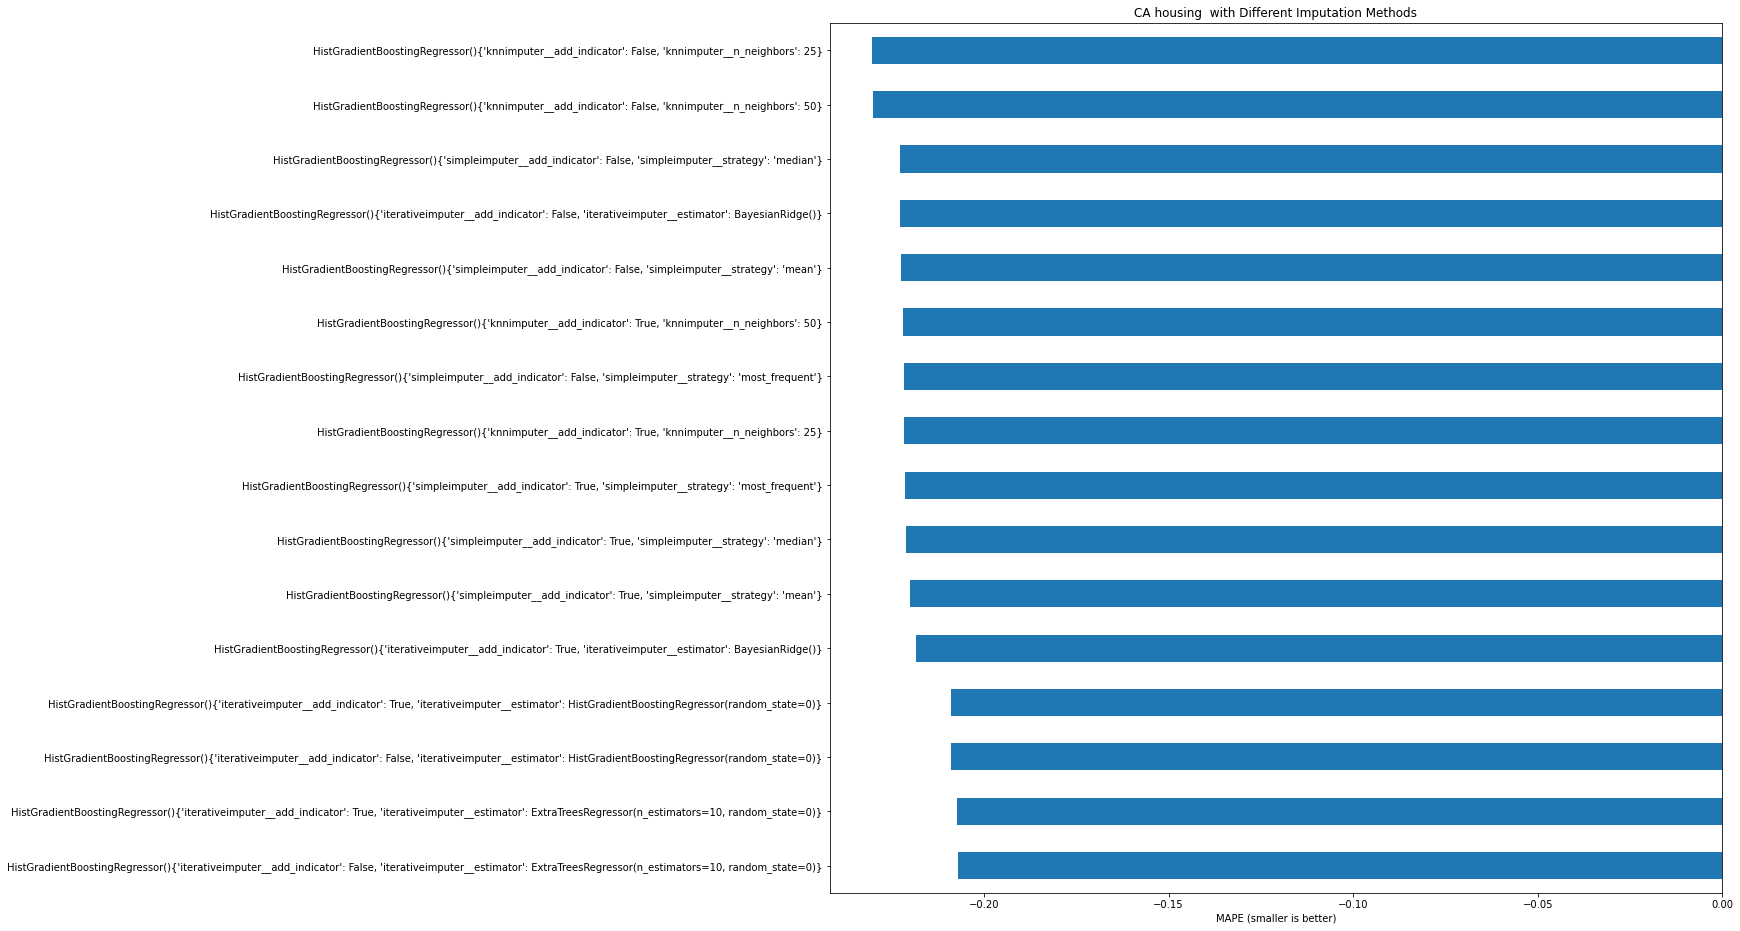

In [232]:
plot_results(df_results, 'CA housing', col= 'mean_test_score')

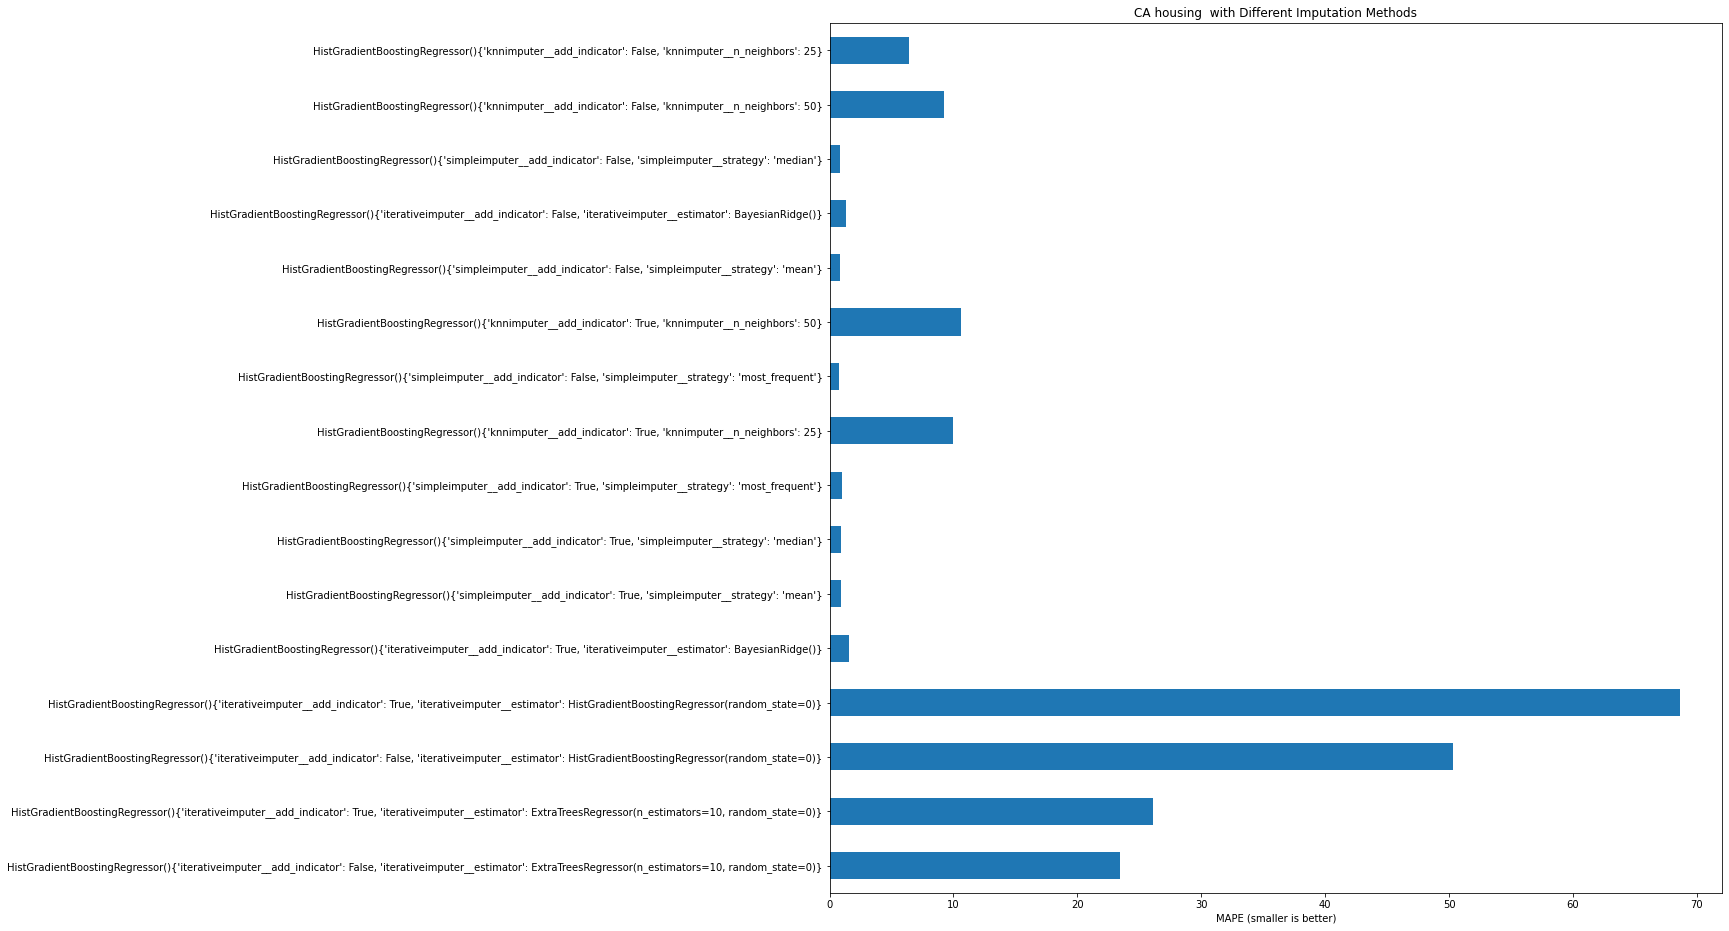

In [233]:
plot_results(df_results, 'CA housing', col= 'mean_fit_time')

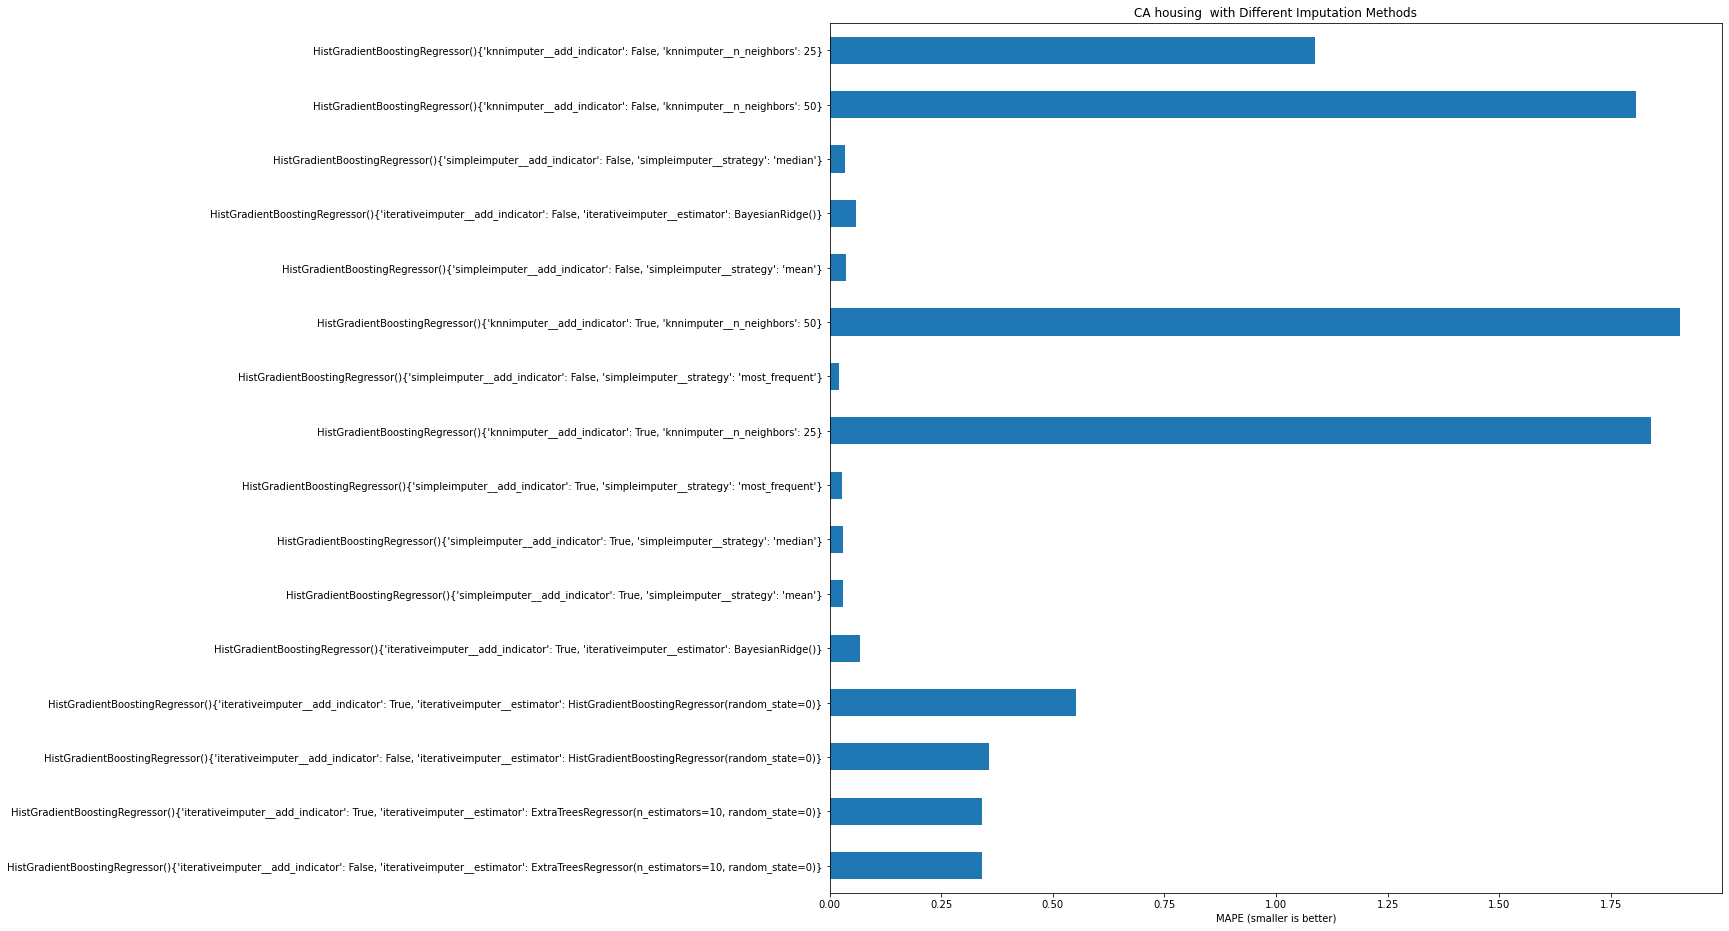

In [234]:
plot_results(df_results, 'CA housing', col= 'mean_score_time')

### Iterative imputers

Main takeaways:
1. the imputation strategy can matter ALOT for performance.
2. Multiple imputation works best.

### Next steps

ames then all cols

Bayesian ridge iterative imputer did second best in the docs example when only using 1/10 of the data - not so with all the data.

would categorical columns with missing data need a classifiction algo for iterative imputation?

___
## Ames
Let's try another dataset

In [135]:
ames = pd.read_csv('https://raw.githubusercontent.com/melindaleung/Ames-Iowa-Housing-Dataset/master/data/ames%20iowa%20housing.csv')
ames.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [136]:
df_numeric = ames.select_dtypes(include=np.number)

In [137]:
df_numeric = df_numeric.sample(10000, random_state=0)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
y = df_numeric['SalePrice']
X = df_numeric.drop(columns='SalePrice')

In [ ]:
X.info()

# See how it does dropping
does well even with dropping non-numeric columns - down to 10% MAPE

In [138]:
X = make_missing(X)
X.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1.0,60.0,65.0,8450.0,7.0,NaN,2003.0,2003.0,196.0,NaN,...,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,NaN,2008.0
1,NaN,20.0,80.0,9600.0,NaN,NaN,1976.0,1976.0,0.0,978.0,...,NaN,298.0,NaN,NaN,0.0,0.0,NaN,0.0,5.0,2007.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,NaN,2002.0,162.0,486.0,...,608.0,NaN,42.0,0.0,NaN,NaN,0.0,0.0,NaN,2008.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,NaN,...,642.0,0.0,35.0,272.0,NaN,0.0,NaN,NaN,2.0,2006.0
4,NaN,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,836.0,192.0,NaN,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


In [139]:
X.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1.0,60.0,65.0,8450.0,7.0,NaN,2003.0,2003.0,196.0,NaN,...,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,NaN,2008.0
1,NaN,20.0,80.0,9600.0,NaN,NaN,1976.0,1976.0,0.0,978.0,...,NaN,298.0,NaN,NaN,0.0,0.0,NaN,0.0,5.0,2007.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,NaN,2002.0,162.0,486.0,...,608.0,NaN,42.0,0.0,NaN,NaN,0.0,0.0,NaN,2008.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,NaN,...,642.0,0.0,35.0,272.0,NaN,0.0,NaN,NaN,2.0,2006.0
4,NaN,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,836.0,192.0,NaN,0.0,0.0,0.0,0.0,0.0,12.0,2008.0


In [140]:
X.shape

(1460, 37)

### Take a sample and make missing values

In [141]:
df_ames = combine_all_continuous(X, y, estimator_list=[HistGradientBoostingRegressor()])
df_ames

/Users/jeffhale/miniconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_simpleimputer__add_indicator,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model,param_knnimputer__add_indicator,param_knnimputer__n_neighbors,param_iterativeimputer__add_indicator,param_iterativeimputer__estimator
0,1.183877,0.027381,0.014721,0.000800,True,mean,"{'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'mean'}",-0.115690,-0.133608,-0.116999,-0.114384,-0.120472,-0.120230,0.006989,1,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
1,1.197429,0.013435,0.015362,0.001290,True,median,"{'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'median'}",-0.120388,-0.130773,-0.116031,-0.122681,-0.127618,-0.123498,0.005215,5,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
2,1.225117,0.033514,0.013181,0.000392,True,most_frequent,"{'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'most_frequent'}",-0.112363,-0.132206,-0.119985,-0.122238,-0.130392,-0.123437,0.007229,4,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
3,0.916810,0.032939,0.014091,0.001411,False,mean,"{'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'mean'}",-0.116512,-0.132444,-0.119266,-0.113419,-0.124247,-0.121177,0.006663,2,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
4,0.839472,0.083799,0.011377,0.001537,False,median,"{'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'median'}",-0.122204,-0.132964,-0.122169,-0.125244,-0.123424,-0.125201,0.004040,6,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
5,0.642229,0.014491,0.007979,0.000598,False,most_frequent,"{'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'most_frequent'}",-0.113644,-0.129311,-0.118751,-0.119781,-0.135593,-0.123416,0.007918,3,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
0,1.736730,0.018845,0.140421,0.004398,NaN,NaN,"{'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 19}",-0.118400,-0.126147,-0.114192,-0.114677,-0.123748,-0.119433,0.004793,3,HistGradientBoostingRegressor(),True,19,NaN,NaN
1,1.731186,0.061093,0.138961,0.009941,NaN,NaN,"{'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 9}",-0.114985,-0.127081,-0.111611,-0.118960,-0.123870,-0.119301,0.005644,1,HistGradientBoostingRegressor(),True,9,NaN,NaN
2,1.576781,0.072286,0.205621,0.030012,NaN,NaN,"{'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 19}",-0.120335,-0.122908,-0.115278,-0.115158,-0.123271,-0.119390,0.003554,2,HistGradientBoostingRegressor(),False,19,NaN,NaN
3,0.960889,0.276149,0.107067,0.055402,NaN,NaN,"{'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 9}",-0.115881,-0.126199,-0.112393,-0.121504,-0.123851,-0.119966,0.005106,4,HistGradientBoostingRegressor(),False,9,NaN,NaN


In [142]:
df_ames = prep_results(df_ames)
df_ames

<ipython-input-129-2c88ce738069>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['mean_score'] = -results['mean_test_score']
<ipython-input-129-2c88ce738069>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['info'] = results['model'] + results['params'].astype(str)


,info,mean_test_score,mean_fit_time,mean_score_time,std_test_score
0,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': False, 'iterativeimputer__estimator': HistGradientBoostingRegressor(random_state=0)}",-0.108488,304.651621,1.045538,0.004379
1,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': False, 'iterativeimputer__estimator': ExtraTreesRegressor(n_estimators=10, random_state=0)}",-0.108644,32.229535,1.056290,0.005501
2,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': HistGradientBoostingRegressor(random_state=0)}",-0.109135,396.308536,1.911579,0.005070
3,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': ExtraTreesRegressor(n_estimators=10, random_state=0)}",-0.109161,31.428932,1.006261,0.006111
4,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': False, 'iterativeimputer__estimator': BayesianRidge()}",-0.114129,3.877376,0.145708,0.008417
5,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': BayesianRidge()}",-0.114469,3.581842,0.126427,0.007960
6,"HistGradientBoostingRegressor(){'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 9}",-0.119301,1.731186,0.138961,0.005644
7,"HistGradientBoostingRegressor(){'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 19}",-0.119390,1.576781,0.205621,0.003554
8,"HistGradientBoostingRegressor(){'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 19}",-0.119433,1.736730,0.140421,0.004793
9,"HistGradientBoostingRegressor(){'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 9}",-0.119966,0.960889,0.107067,0.005106


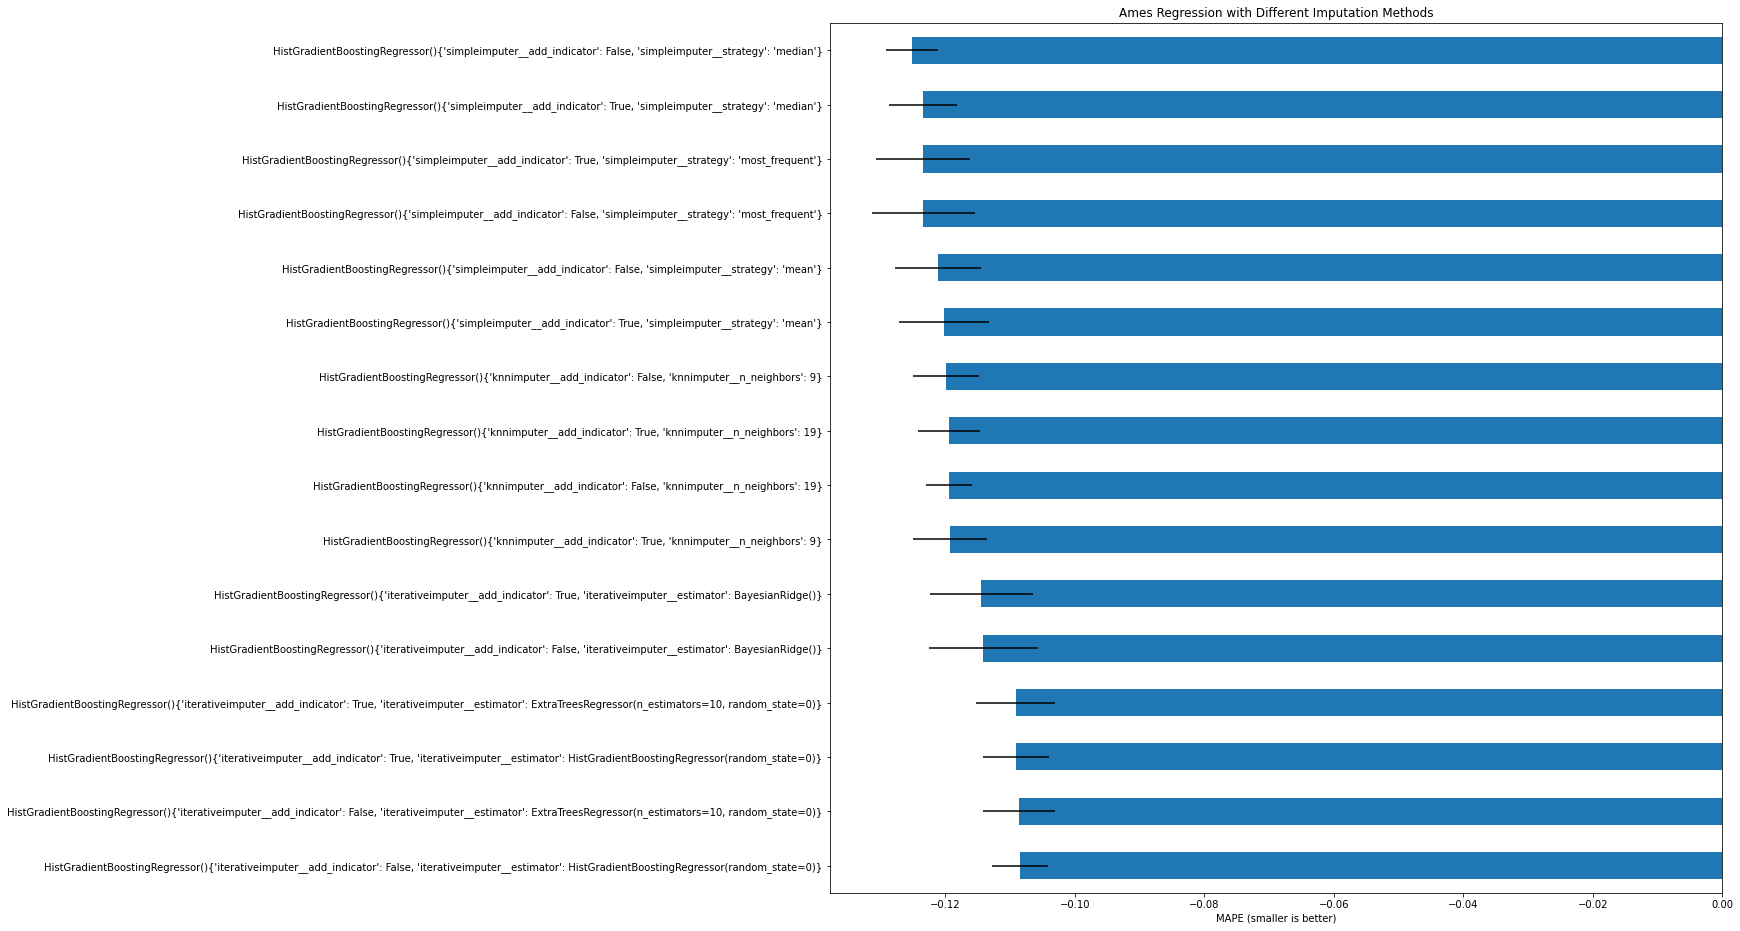

In [143]:
plot_results(df_results, 'Ames', col= 'mean_fit_time')

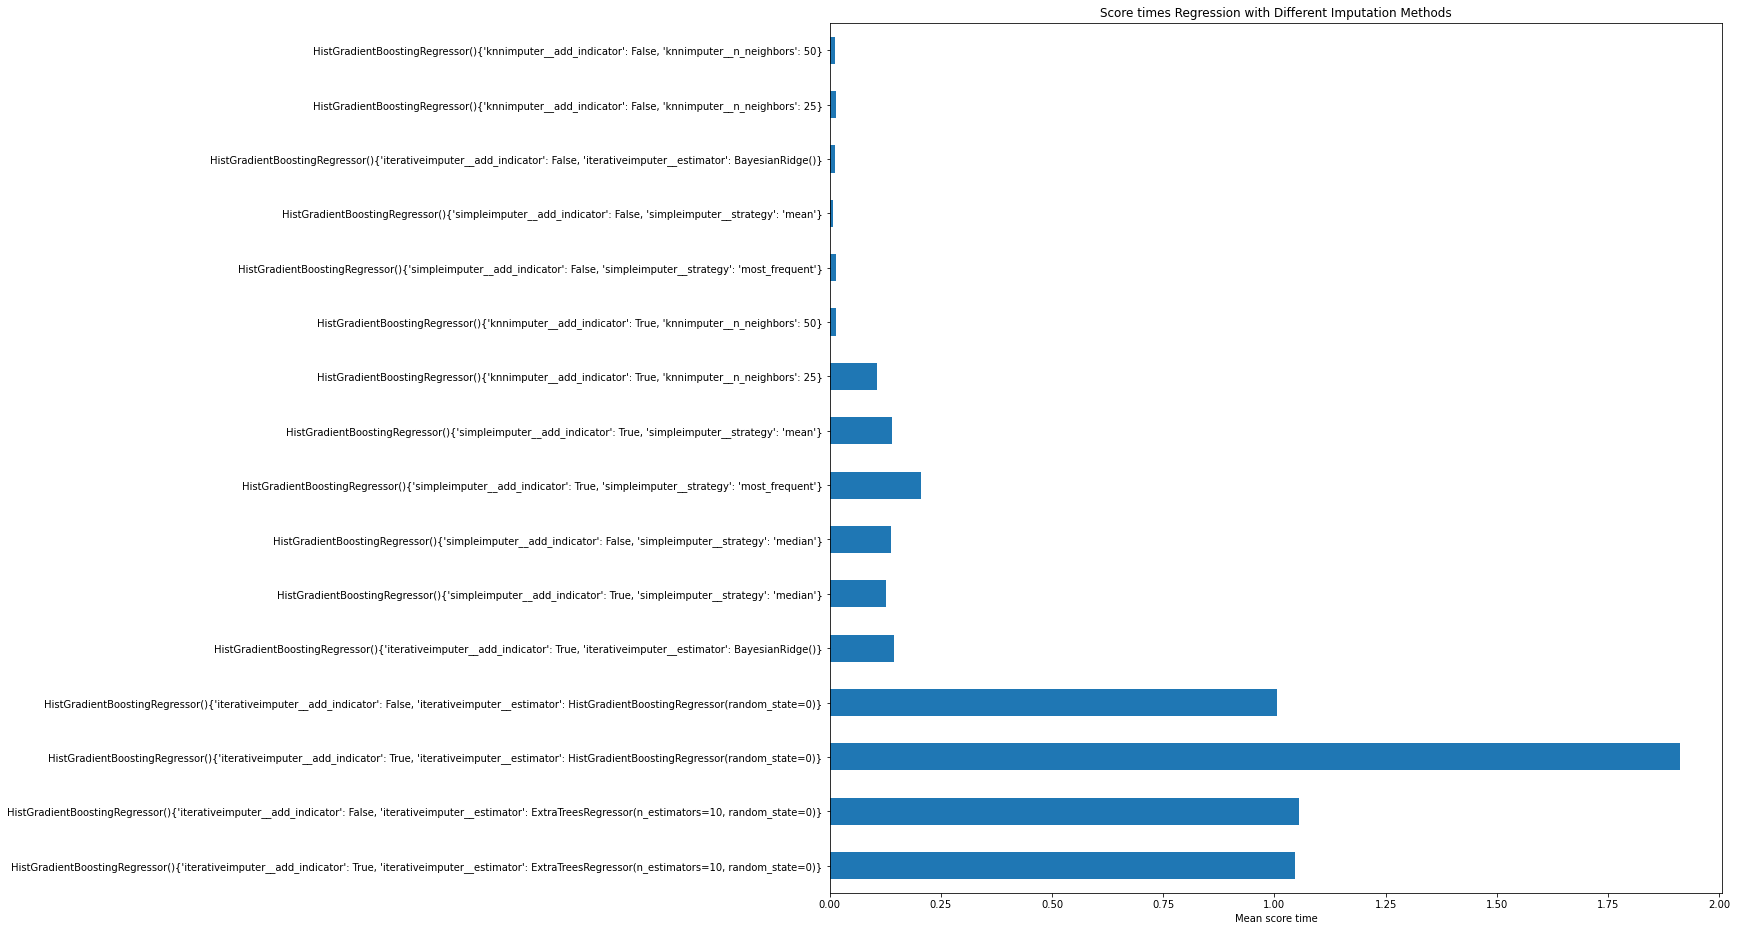

In [144]:
plot_results(df_results, 'Ames', col= 'mean_score_time')

## Analysis

Also for Ames.
HGBR with II with ETR(10 trees) or HGBR best score. w or w/o indicator column.
BayesianRidge imputing much faster at fitting and scoring if those are priorities and willing to sacrifice a little score.

Caveats, no categorical columns (some ordinal).
10k observations in both cases.
Both housing regression cases.
Probably easier for Ames because more homogenous housing stock and no ocean vies and more features.
Ames had missin gdata to start, too. 

## Diamonds

In [146]:
diamonds = pd.read_csv('https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [147]:
diamonds = diamonds.select_dtypes(include=np.number)

In [148]:
df_numeric = diamonds.sample(10000, random_state=0)

In [149]:
y = df_numeric['price']
X = df_numeric.drop(columns='price')

In [150]:
X = make_missing(X)
X.head()

,carat,depth,table,x,y,z
10176,NaN,62.0,NaN,6.61,NaN,4.11
16083,1.29,NaN,56.0,6.96,6.93,4.35
13420,1.20,61.1,58.0,6.88,6.80,4.18
20407,1.50,60.9,56.0,7.43,7.36,4.50
8909,NaN,NaN,57.0,6.17,6.21,3.82


In [151]:
df_diamonds = combine_all_continuous(X, y, estimator_list=[HistGradientBoostingRegressor()])
df_diamonds

/Users/jeffhale/miniconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_simpleimputer__add_indicator,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model,param_knnimputer__add_indicator,param_knnimputer__n_neighbors,param_iterativeimputer__add_indicator,param_iterativeimputer__estimator
0,0.935108,0.013010,0.031416,0.000918,True,mean,"{'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'mean'}",-0.212533,-0.212464,-0.207470,-0.204475,-0.210132,-0.209415,0.003089,3,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
1,0.910126,0.036287,0.034620,0.003582,True,median,"{'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'median'}",-0.212784,-0.212093,-0.208673,-0.206028,-0.210985,-0.210113,0.002473,5,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
2,0.868026,0.007229,0.037379,0.003385,True,most_frequent,"{'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'most_frequent'}",-0.212604,-0.211956,-0.203894,-0.203307,-0.210096,-0.208371,0.003986,1,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
3,0.784972,0.009006,0.040385,0.007406,False,mean,"{'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'mean'}",-0.212857,-0.211754,-0.207675,-0.205792,-0.210307,-0.209677,0.002605,4,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
4,0.764928,0.063752,0.045334,0.010158,False,median,"{'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'median'}",-0.213280,-0.213480,-0.208090,-0.205386,-0.210731,-0.210193,0.003103,6,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
5,0.602613,0.007874,0.028147,0.002440,False,most_frequent,"{'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'most_frequent'}",-0.214319,-0.212038,-0.203239,-0.202629,-0.210452,-0.208535,0.004740,2,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
0,8.418945,0.242899,1.659429,0.135908,NaN,NaN,"{'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 50}",-0.211182,-0.207725,-0.199511,-0.200557,-0.208579,-0.205511,0.004626,2,HistGradientBoostingRegressor(),True,50,NaN,NaN
1,8.092867,0.620990,1.455450,0.353615,NaN,NaN,"{'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 25}",-0.209105,-0.208300,-0.202022,-0.201993,-0.208356,-0.205955,0.003236,4,HistGradientBoostingRegressor(),True,25,NaN,NaN
2,7.321943,0.054656,1.359248,0.043721,NaN,NaN,"{'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 50}",-0.210545,-0.207836,-0.198814,-0.200797,-0.207481,-0.205095,0.004491,1,HistGradientBoostingRegressor(),False,50,NaN,NaN
3,4.720990,1.277747,0.752017,0.290319,NaN,NaN,"{'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 25}",-0.209540,-0.208648,-0.200658,-0.201977,-0.208300,-0.205824,0.003726,3,HistGradientBoostingRegressor(),False,25,NaN,NaN


In [152]:
df_diamonds = prep_results(df_diamonds)
df_diamonds

<ipython-input-129-2c88ce738069>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['mean_score'] = -results['mean_test_score']
<ipython-input-129-2c88ce738069>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['info'] = results['model'] + results['params'].astype(str)


,info,mean_test_score,mean_fit_time,mean_score_time,std_test_score
0,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': False, 'iterativeimputer__estimator': ExtraTreesRegressor(n_estimators=10, random_state=0)}",-0.201788,14.478264,0.306171,0.004035
1,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': False, 'iterativeimputer__estimator': HistGradientBoostingRegressor(random_state=0)}",-0.202100,38.641504,0.282447,0.003941
2,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': ExtraTreesRegressor(n_estimators=10, random_state=0)}",-0.202327,14.371824,0.303277,0.003933
3,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': HistGradientBoostingRegressor(random_state=0)}",-0.202546,52.869880,0.503512,0.003889
4,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': False, 'iterativeimputer__estimator': BayesianRidge()}",-0.202799,1.325355,0.073248,0.004300
5,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': BayesianRidge()}",-0.203056,1.252852,0.057098,0.004245
6,"HistGradientBoostingRegressor(){'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 50}",-0.205095,7.321943,1.359248,0.004491
7,"HistGradientBoostingRegressor(){'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 50}",-0.205511,8.418945,1.659429,0.004626
8,"HistGradientBoostingRegressor(){'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 25}",-0.205824,4.720990,0.752017,0.003726
9,"HistGradientBoostingRegressor(){'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 25}",-0.205955,8.092867,1.455450,0.003236


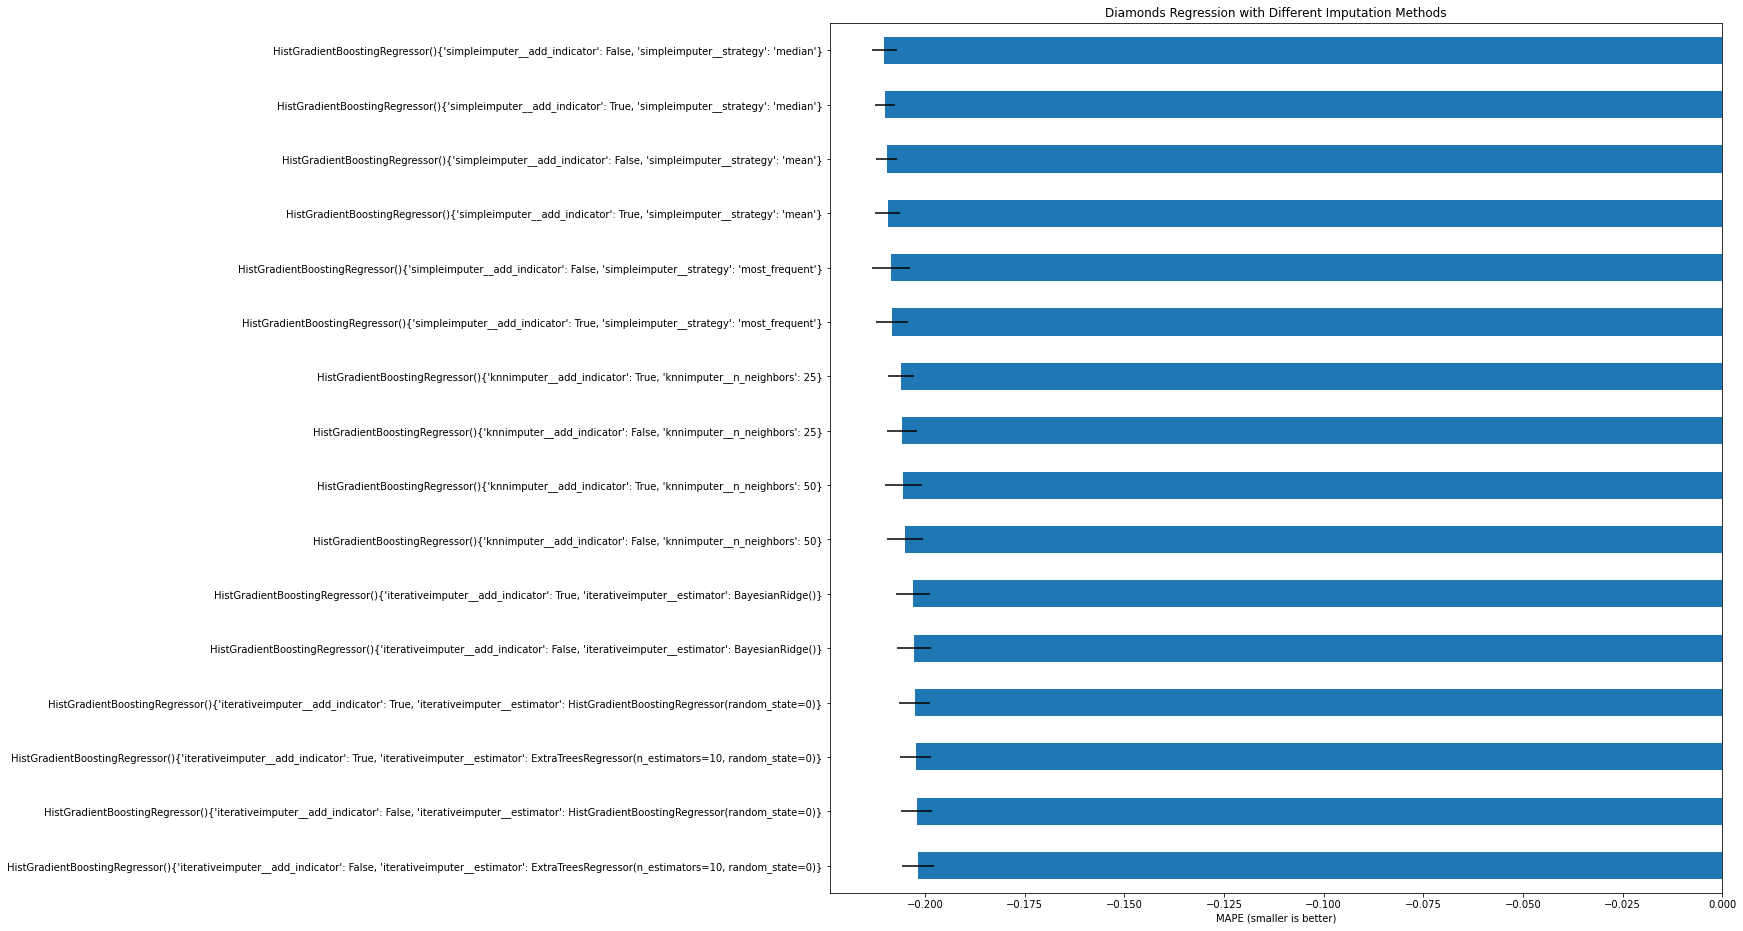

In [153]:
plot_results(df_diamonds, 'Diamonds ')

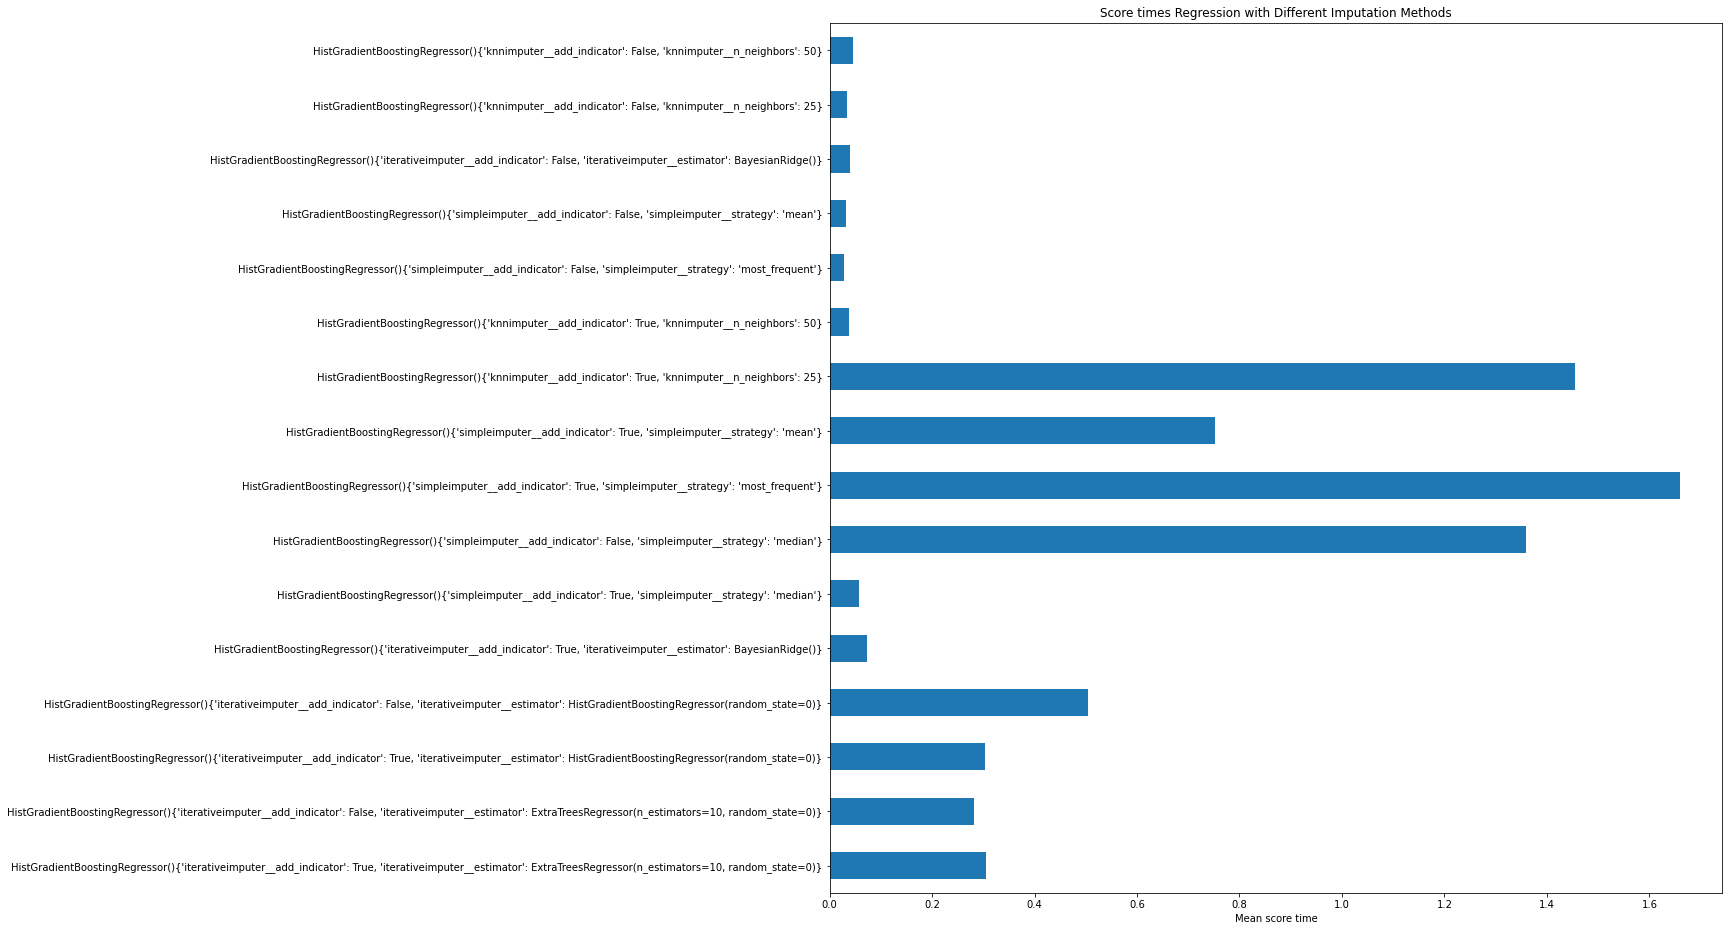

In [154]:
plot_results(df_results, 'diamonds', col= 'mean_test_score')

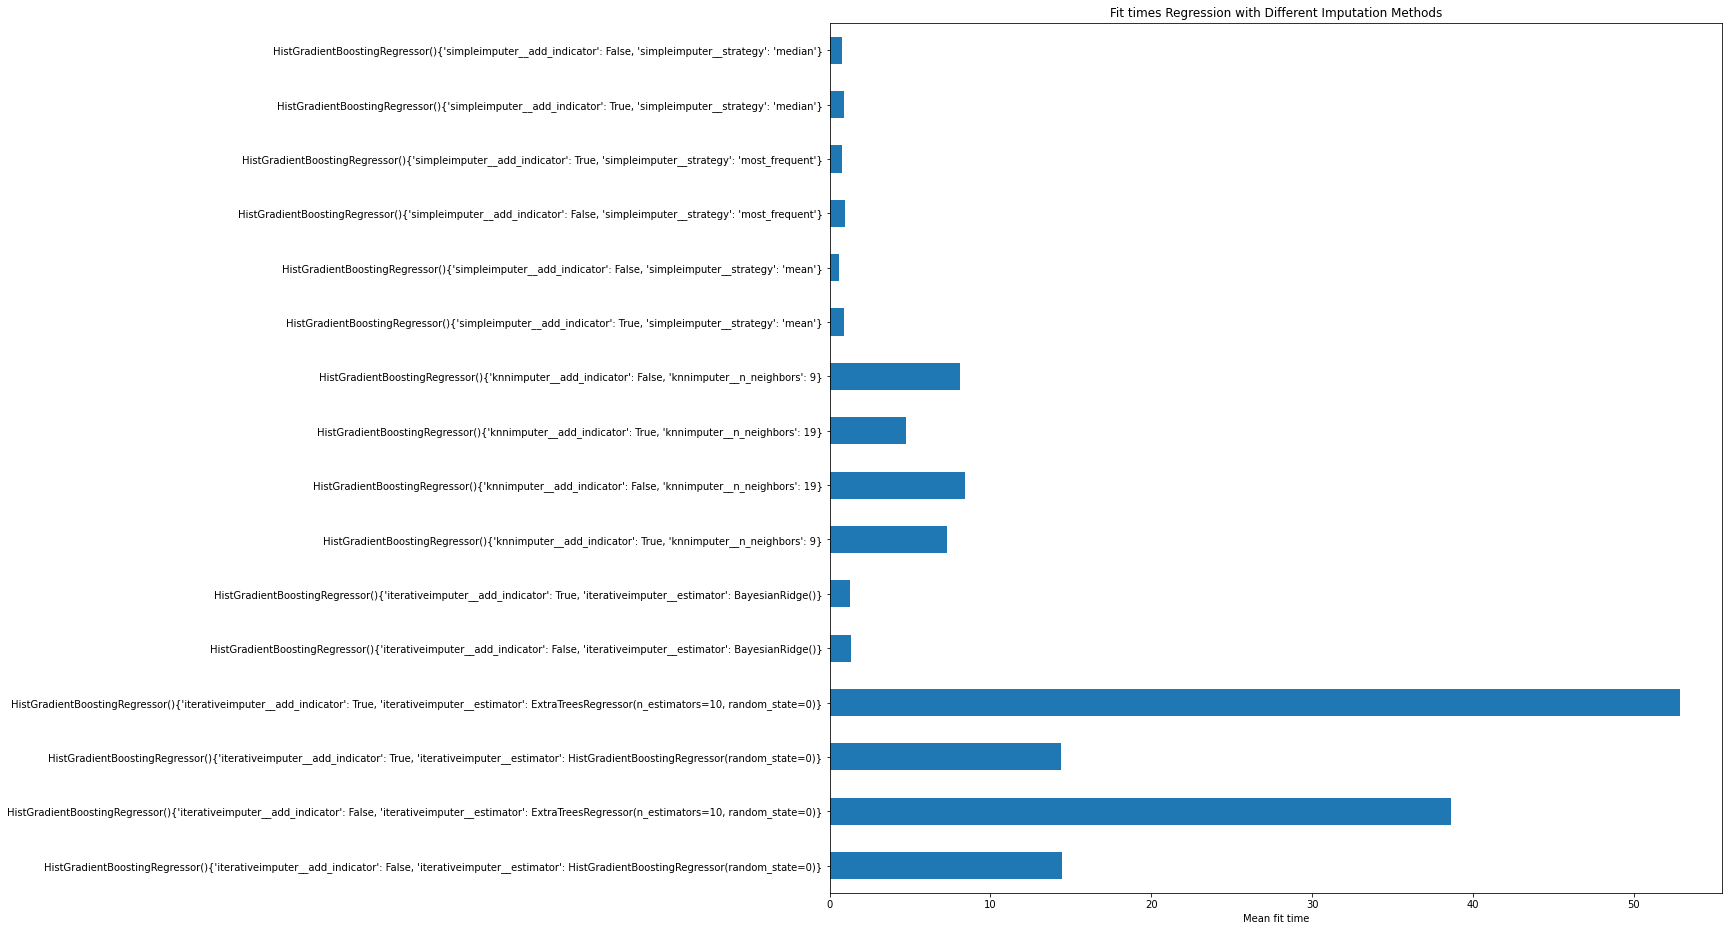

In [155]:
plot_results(df_results, 'diamonds', col= 'mean_fit_time')

Diamonds dataset shows the usual pattern. If you want the best results use HGBR with imputing via HGBR or ETR(trees=10). Look at bayes if you need faster prediction or training.

 ## Tips dataset
 1 person's tips

In [163]:
import seaborn as sns
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [172]:
for col in tips[['sex', 'smoker', 'day', 'time']].columns:
    tips[col] = tips[col].factorize()[0]  # should technically OHE day, but this should be good enough

In [175]:
tips.sample(5)

,total_bill,tip,sex,smoker,day,time,size
144,16.43,2.3,0,0,2,1,2
176,17.89,2.0,1,1,0,0,2
188,18.15,3.5,0,1,0,0,3
51,10.29,2.6,0,0,0,0,2
214,28.17,6.5,0,1,1,0,3


In [176]:
tips.shape

(244, 7)

In [177]:
y = tips['total_bill']
X = tips.drop(columns='total_bill')

In [178]:
X = make_missing(X)
X.head()

,tip,sex,smoker,day,time,size
0,1.01,0.0,0.0,0.0,0.0,2.0
1,1.66,1.0,NaN,0.0,0.0,3.0
2,3.50,1.0,0.0,0.0,0.0,3.0
3,NaN,1.0,0.0,0.0,0.0,2.0
4,3.61,0.0,0.0,NaN,0.0,4.0


In [179]:
results = combine_all_continuous(X, y, estimator_list=[HistGradientBoostingRegressor()])
results

/Users/jeffhale/miniconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_simpleimputer__add_indicator,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model,param_knnimputer__add_indicator,param_knnimputer__n_neighbors,param_iterativeimputer__add_indicator,param_iterativeimputer__estimator
0,0.187772,0.008462,0.009634,0.002694,True,mean,"{'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'mean'}",-0.268872,-0.325616,-0.294521,-0.325097,-0.292315,-0.301284,0.021614,4,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
1,0.180343,0.011448,0.007799,0.001115,True,median,"{'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'median'}",-0.272323,-0.333882,-0.266810,-0.329857,-0.303882,-0.301351,0.027975,5,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
2,0.164667,0.001976,0.008159,0.001112,True,most_frequent,"{'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'most_frequent'}",-0.281355,-0.321707,-0.243232,-0.347016,-0.318349,-0.302332,0.036225,6,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
3,0.139190,0.012360,0.007374,0.000781,False,mean,"{'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'mean'}",-0.267012,-0.323583,-0.287826,-0.328755,-0.293404,-0.300116,0.023077,2,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
4,0.121079,0.012916,0.007118,0.001059,False,median,"{'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'median'}",-0.283455,-0.329997,-0.254403,-0.329871,-0.303681,-0.300281,0.028838,3,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
5,0.102763,0.003251,0.004096,0.000388,False,most_frequent,"{'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'most_frequent'}",-0.282218,-0.317278,-0.219263,-0.349436,-0.331622,-0.299963,0.045994,1,HistGradientBoostingRegressor(),NaN,NaN,NaN,NaN
0,0.160969,0.015493,0.014273,0.001711,NaN,NaN,"{'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 7}",-0.258066,-0.317201,-0.248836,-0.346021,-0.291071,-0.292239,0.036245,3,HistGradientBoostingRegressor(),True,7,NaN,NaN
1,0.160263,0.005301,0.013054,0.001289,NaN,NaN,"{'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 3}",-0.268723,-0.289102,-0.232647,-0.348597,-0.319782,-0.291770,0.040119,2,HistGradientBoostingRegressor(),True,3,NaN,NaN
2,0.142424,0.002475,0.011554,0.000912,NaN,NaN,"{'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 7}",-0.258048,-0.303083,-0.248893,-0.346986,-0.300090,-0.291420,0.035273,1,HistGradientBoostingRegressor(),False,7,NaN,NaN
3,0.113026,0.010352,0.008377,0.001461,NaN,NaN,"{'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 3}",-0.269288,-0.294423,-0.228591,-0.353740,-0.327060,-0.294620,0.043701,4,HistGradientBoostingRegressor(),False,3,NaN,NaN


In [180]:
results = prep_results(results)
results

<ipython-input-129-2c88ce738069>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['mean_score'] = -results['mean_test_score']
<ipython-input-129-2c88ce738069>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['info'] = results['model'] + results['params'].astype(str)


,info,mean_test_score,mean_fit_time,mean_score_time,std_test_score
0,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': ExtraTreesRegressor(n_estimators=10, random_state=0)}",-0.276490,1.403806,0.159258,0.036498
1,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': False, 'iterativeimputer__estimator': ExtraTreesRegressor(n_estimators=10, random_state=0)}",-0.277789,1.515565,0.142802,0.039053
2,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': HistGradientBoostingRegressor(random_state=0)}",-0.282767,8.136031,0.229514,0.021952
3,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': False, 'iterativeimputer__estimator': HistGradientBoostingRegressor(random_state=0)}",-0.284726,5.967173,0.119956,0.015435
4,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': BayesianRidge()}",-0.285655,0.250680,0.018154,0.049135
5,"HistGradientBoostingRegressor(){'iterativeimputer__add_indicator': False, 'iterativeimputer__estimator': BayesianRidge()}",-0.288195,0.265286,0.021276,0.047069
6,"HistGradientBoostingRegressor(){'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 7}",-0.291420,0.142424,0.011554,0.035273
7,"HistGradientBoostingRegressor(){'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 3}",-0.291770,0.160263,0.013054,0.040119
8,"HistGradientBoostingRegressor(){'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 7}",-0.292239,0.160969,0.014273,0.036245
9,"HistGradientBoostingRegressor(){'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 3}",-0.294620,0.113026,0.008377,0.043701


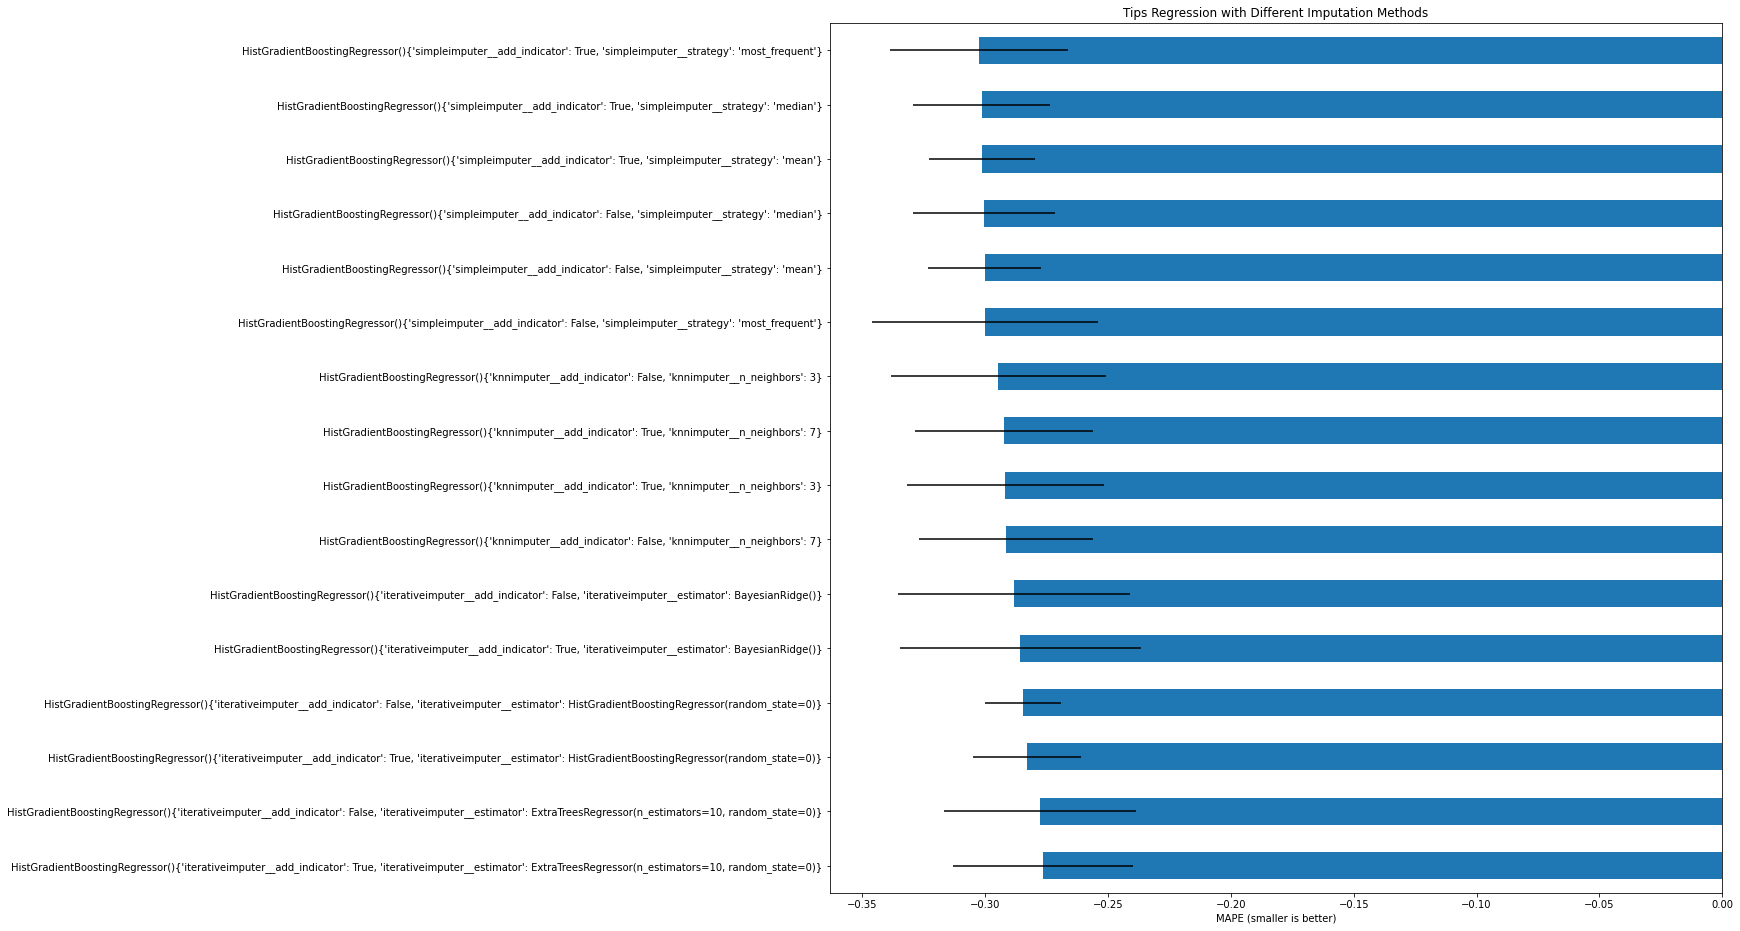

In [183]:
plot_results(results, 'Tips', col= 'mean_test_score')

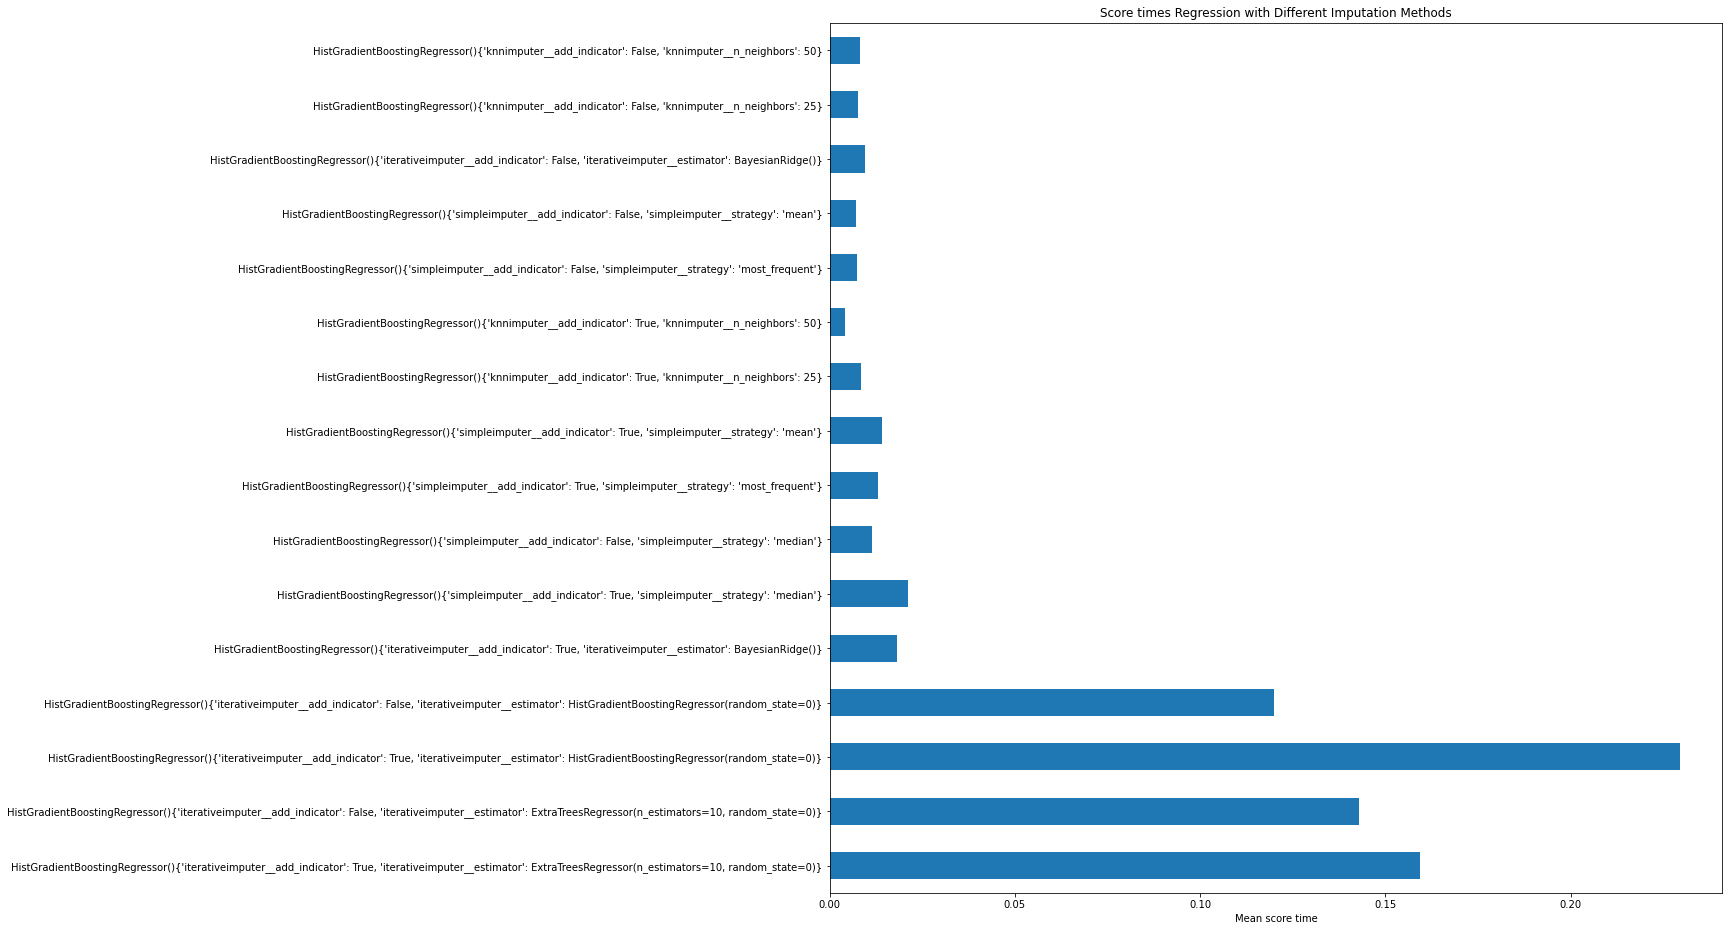

In [184]:
plot_results(results, 'Tips', col= 'mean_fit_time')

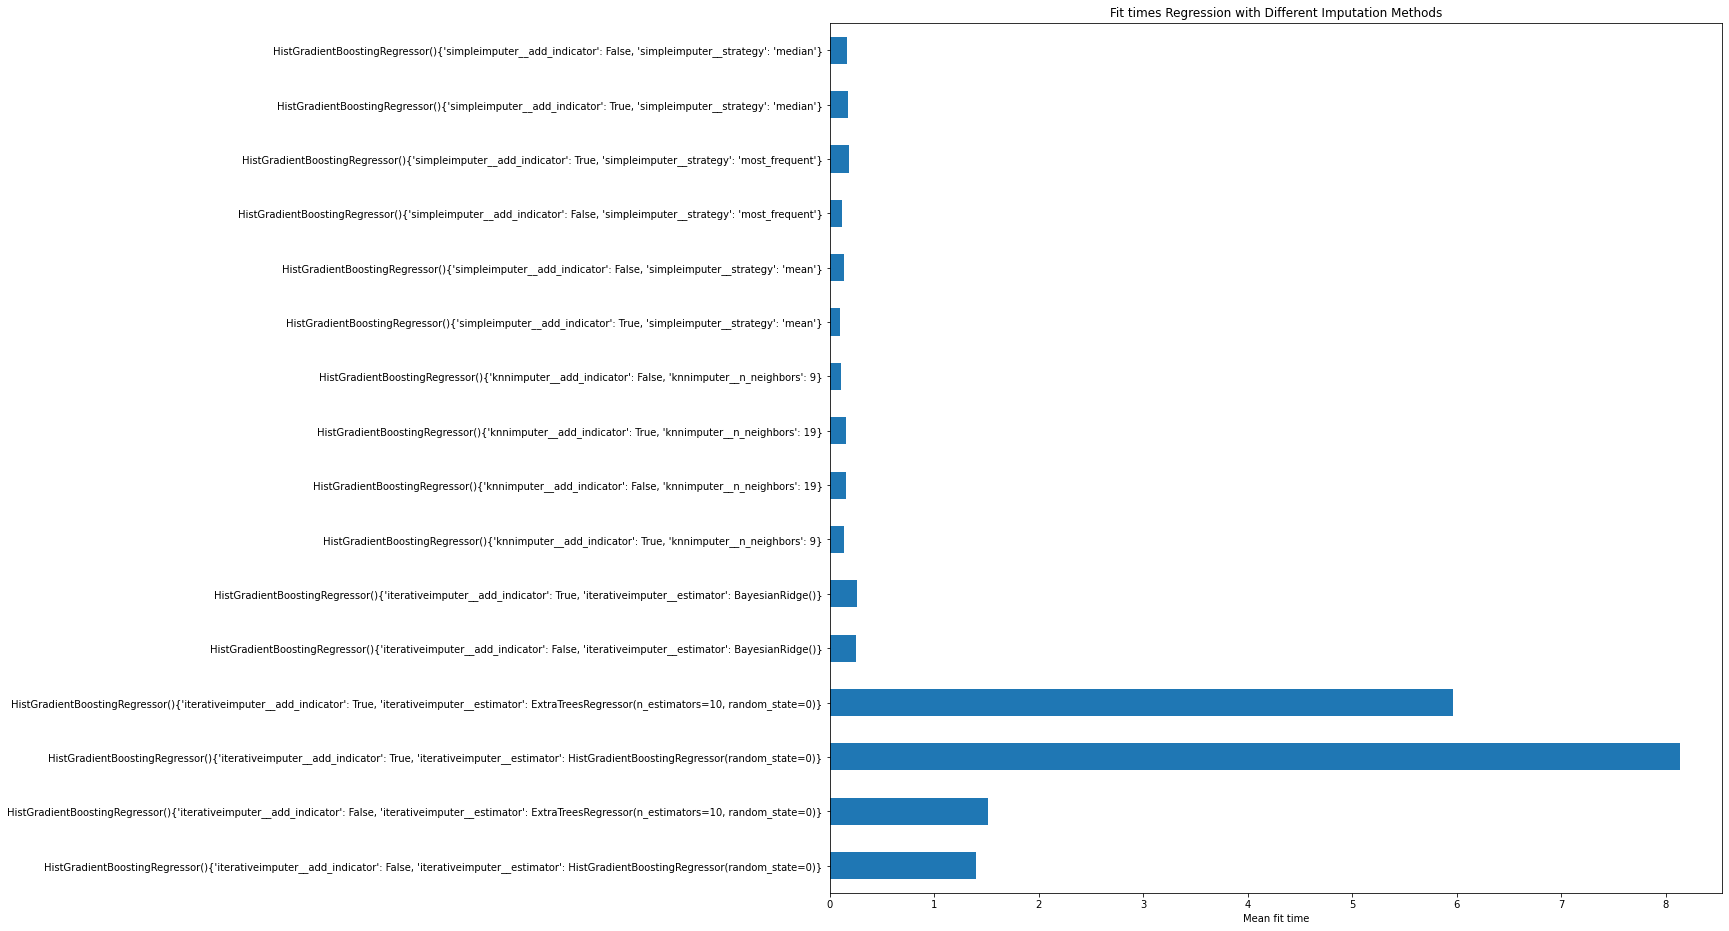

In [185]:
plot_results(df_results, 'Tips', col= 'mean_score_time')

# Check why row order changes but isn't ordered by time.

## Titanic

Iris and penguins and mushrooms maybe too easy.

In [195]:
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [196]:
titanic = titanic.drop(columns=['alive', 'alone', 'who', 'adult_male', 'embark_town'])
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck
0,0,3,male,22.0,1,0,7.2500,S,Third,NaN
1,1,1,female,38.0,1,0,71.2833,C,First,C
2,1,3,female,26.0,0,0,7.9250,S,Third,NaN
3,1,1,female,35.0,1,0,53.1000,S,First,C
4,0,3,male,35.0,0,0,8.0500,S,Third,NaN


In [197]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   survived  891 non-null    int64   
 1   pclass    891 non-null    int64   
 2   sex       891 non-null    object  
 3   age       714 non-null    float64 
 4   sibsp     891 non-null    int64   
 5   parch     891 non-null    int64   
 6   fare      891 non-null    float64 
 7   embarked  889 non-null    object  
 8   class     891 non-null    category
 9   deck      203 non-null    category
dtypes: category(2), float64(2), int64(4), object(2)
memory usage: 58.0+ KB


In [199]:
for col in titanic[['sex', 'embarked', 'class', 'deck'] ].columns:
    titanic[col] = titanic[col].factorize()[0]  # should technically OHE day, but this should be good enough

In [200]:
titanic.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck
658,0,2,0,23.0,0,0,13.0000,0,2,-1
6,0,1,0,54.0,0,0,51.8625,0,1,1
462,0,1,0,47.0,0,0,38.5000,0,1,1
771,0,3,0,48.0,0,0,7.8542,0,0,-1
104,0,3,0,37.0,2,0,7.9250,0,0,-1


In [201]:
titanic.shape

(891, 10)

In [202]:
y = titanic['survived']
X = titanic.drop(columns='survived')

In [203]:
X = make_missing(X)
X.head()

,pclass,sex,age,sibsp,parch,fare,embarked,class,deck
0,3.0,0.0,22.0,1.0,0.0,NaN,0.0,0.0,-1.0
1,1.0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,0.0
2,3.0,1.0,26.0,0.0,0.0,7.925,0.0,0.0,-1.0
3,1.0,1.0,35.0,1.0,0.0,53.100,0.0,1.0,0.0
4,3.0,0.0,NaN,0.0,0.0,8.050,0.0,0.0,NaN


In [207]:
results = combine_all_continuous(X, y, estimator_list=[HistGradientBoostingClassifier()])
results

/Users/jeffhale/miniconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_simpleimputer__add_indicator,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model,param_knnimputer__add_indicator,param_knnimputer__n_neighbors,param_iterativeimputer__add_indicator,param_iterativeimputer__estimator
0,0.548313,0.019197,0.012350,0.001463,True,mean,"{'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'mean'}",0.731621,0.745588,0.801203,0.794519,0.834331,0.781452,0.037753,3,HistGradientBoostingClassifier(),NaN,NaN,NaN,NaN
1,0.522067,0.014966,0.010890,0.000653,True,median,"{'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'median'}",0.755204,0.760963,0.796658,0.746925,0.836258,0.779202,0.033198,4,HistGradientBoostingClassifier(),NaN,NaN,NaN,NaN
2,0.526238,0.010410,0.011776,0.001557,True,most_frequent,"{'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'most_frequent'}",0.760606,0.792112,0.811364,0.789973,0.852679,0.801347,0.030364,1,HistGradientBoostingClassifier(),NaN,NaN,NaN,NaN
3,0.514578,0.027144,0.010604,0.002080,False,mean,"{'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'mean'}",0.748814,0.730882,0.825000,0.779813,0.844236,0.785749,0.043292,2,HistGradientBoostingClassifier(),NaN,NaN,NaN,NaN
4,0.492339,0.067290,0.009086,0.001312,False,median,"{'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'median'}",0.744269,0.744519,0.780214,0.727674,0.810663,0.761468,0.029989,5,HistGradientBoostingClassifier(),NaN,NaN,NaN,NaN
5,0.351727,0.007500,0.006927,0.000319,False,most_frequent,"{'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'most_frequent'}",0.732477,0.747326,0.799465,0.708422,0.813323,0.760203,0.039947,6,HistGradientBoostingClassifier(),NaN,NaN,NaN,NaN
0,0.573752,0.007912,0.028237,0.001667,NaN,NaN,"{'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 14}",0.769697,0.778476,0.789305,0.784358,0.836258,0.791619,0.023255,2,HistGradientBoostingClassifier(),True,14,NaN,NaN
1,0.568504,0.010532,0.025732,0.004672,NaN,NaN,"{'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 7}",0.776943,0.789706,0.790374,0.778075,0.822497,0.791519,0.016477,3,HistGradientBoostingClassifier(),True,7,NaN,NaN
2,0.532341,0.009582,0.025681,0.000788,NaN,NaN,"{'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 14}",0.767852,0.772193,0.766578,0.766176,0.857998,0.786159,0.035983,4,HistGradientBoostingClassifier(),False,14,NaN,NaN
3,0.336393,0.103221,0.017479,0.003144,NaN,NaN,"{'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 7}",0.824111,0.805080,0.774599,0.763369,0.848823,0.803196,0.031390,1,HistGradientBoostingClassifier(),False,7,NaN,NaN


In [208]:
results = prep_results(results)
results

<ipython-input-129-2c88ce738069>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['mean_score'] = -results['mean_test_score']
<ipython-input-129-2c88ce738069>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['info'] = results['model'] + results['params'].astype(str)


,info,mean_test_score,mean_fit_time,mean_score_time,std_test_score
0,"HistGradientBoostingClassifier(){'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 7}",0.803196,0.336393,0.017479,0.031390
1,"HistGradientBoostingClassifier(){'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'most_frequent'}",0.801347,0.526238,0.011776,0.030364
2,"HistGradientBoostingClassifier(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': HistGradientBoostingRegressor(random_state=0)}",0.796557,37.216530,0.406795,0.027362
3,"HistGradientBoostingClassifier(){'iterativeimputer__add_indicator': False, 'iterativeimputer__estimator': HistGradientBoostingRegressor(random_state=0)}",0.792519,28.766431,0.223403,0.030129
4,"HistGradientBoostingClassifier(){'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 14}",0.791619,0.573752,0.028237,0.023255
5,"HistGradientBoostingClassifier(){'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 7}",0.791519,0.568504,0.025732,0.016477
6,"HistGradientBoostingClassifier(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': ExtraTreesRegressor(n_estimators=10, random_state=0)}",0.790057,2.826462,0.233693,0.017122
7,"HistGradientBoostingClassifier(){'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 14}",0.786159,0.532341,0.025681,0.035983
8,"HistGradientBoostingClassifier(){'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'mean'}",0.785749,0.514578,0.010604,0.043292
9,"HistGradientBoostingClassifier(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': BayesianRidge()}",0.783481,0.732606,0.032400,0.022586


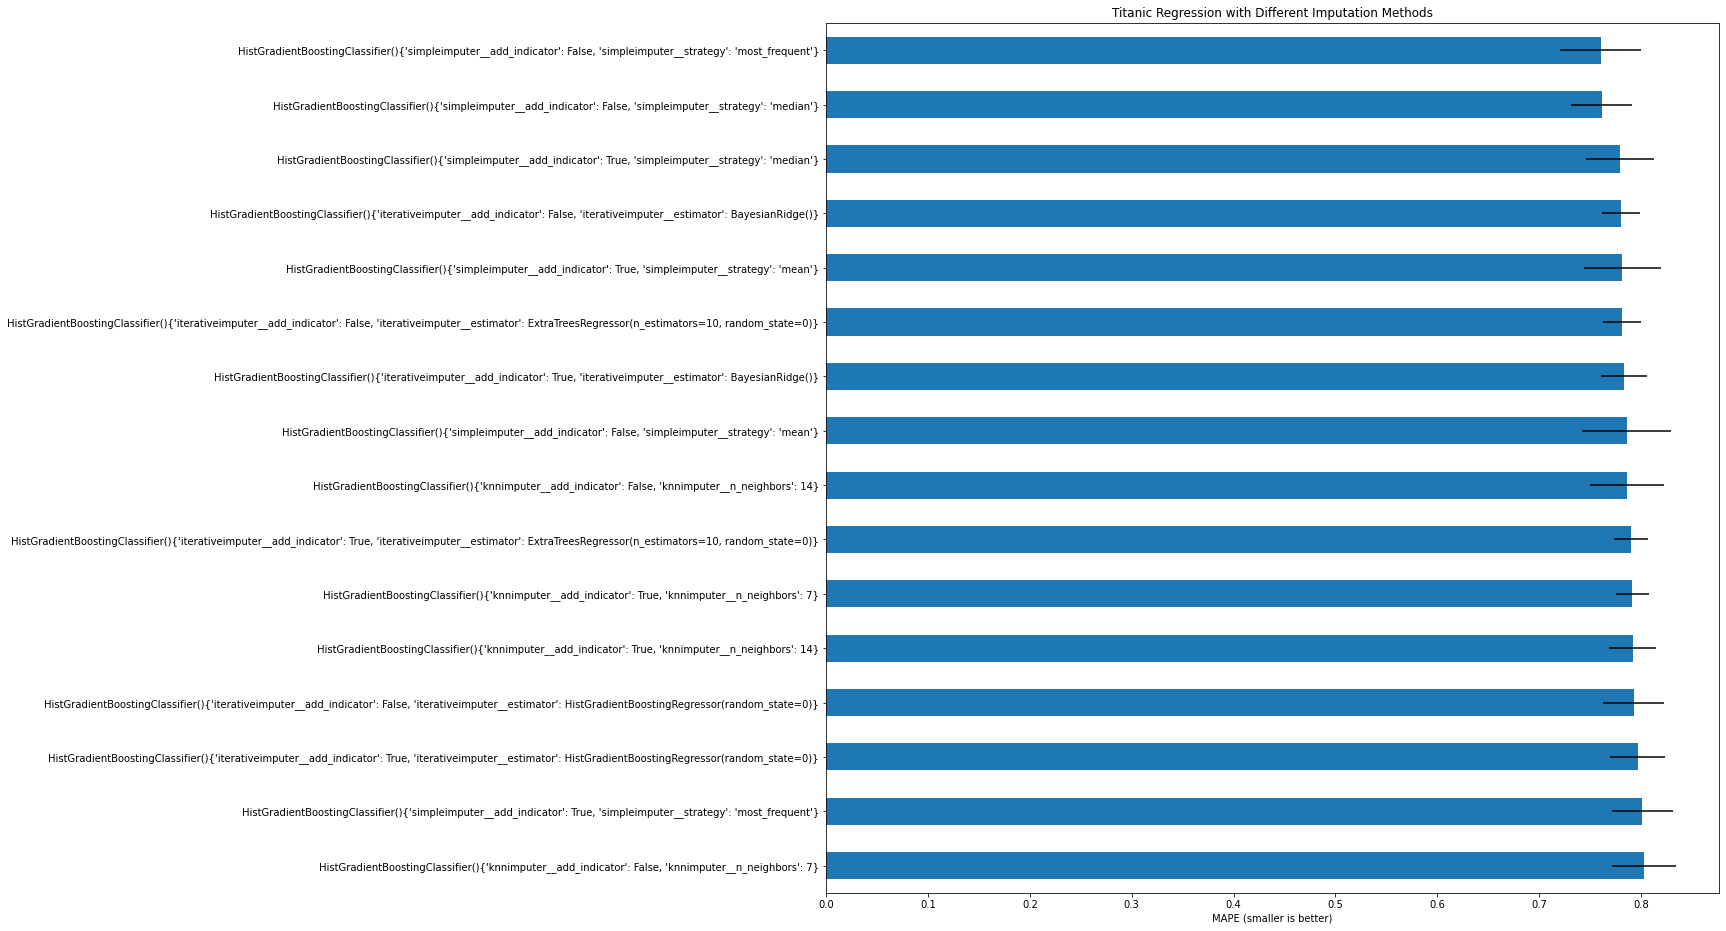

In [209]:
plot_results(results, 'Titanic', col= 'mean_test_score')

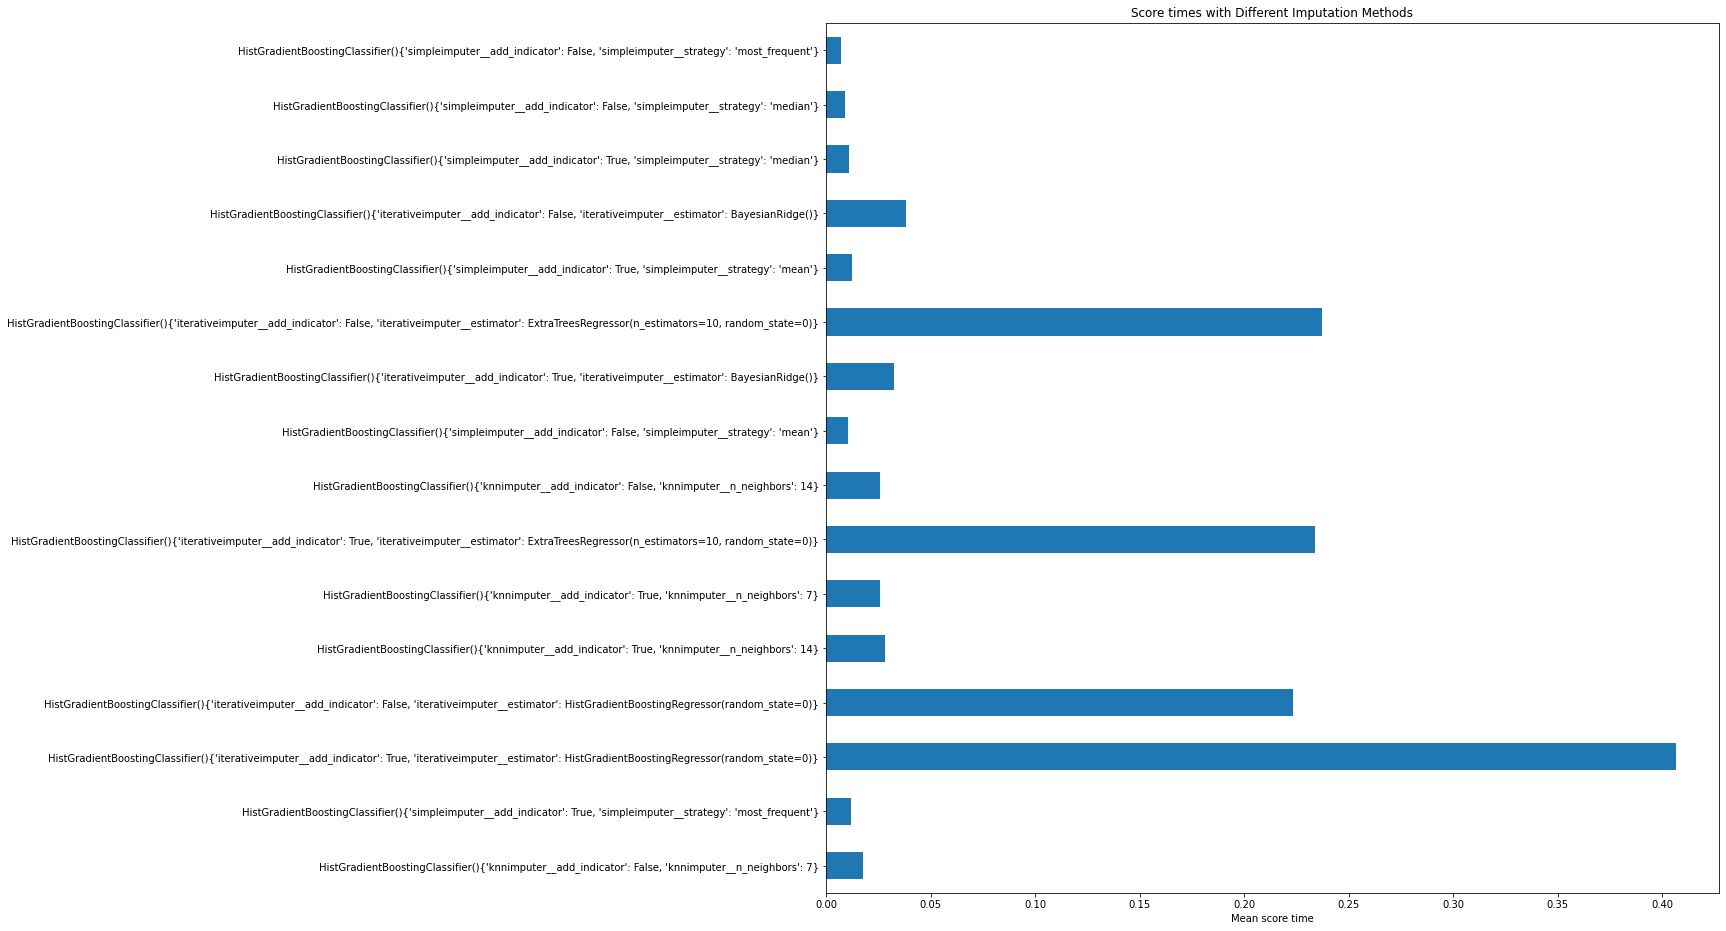

In [211]:
plot_results(df_results, 'Titanic', col= 'mean_score_time')

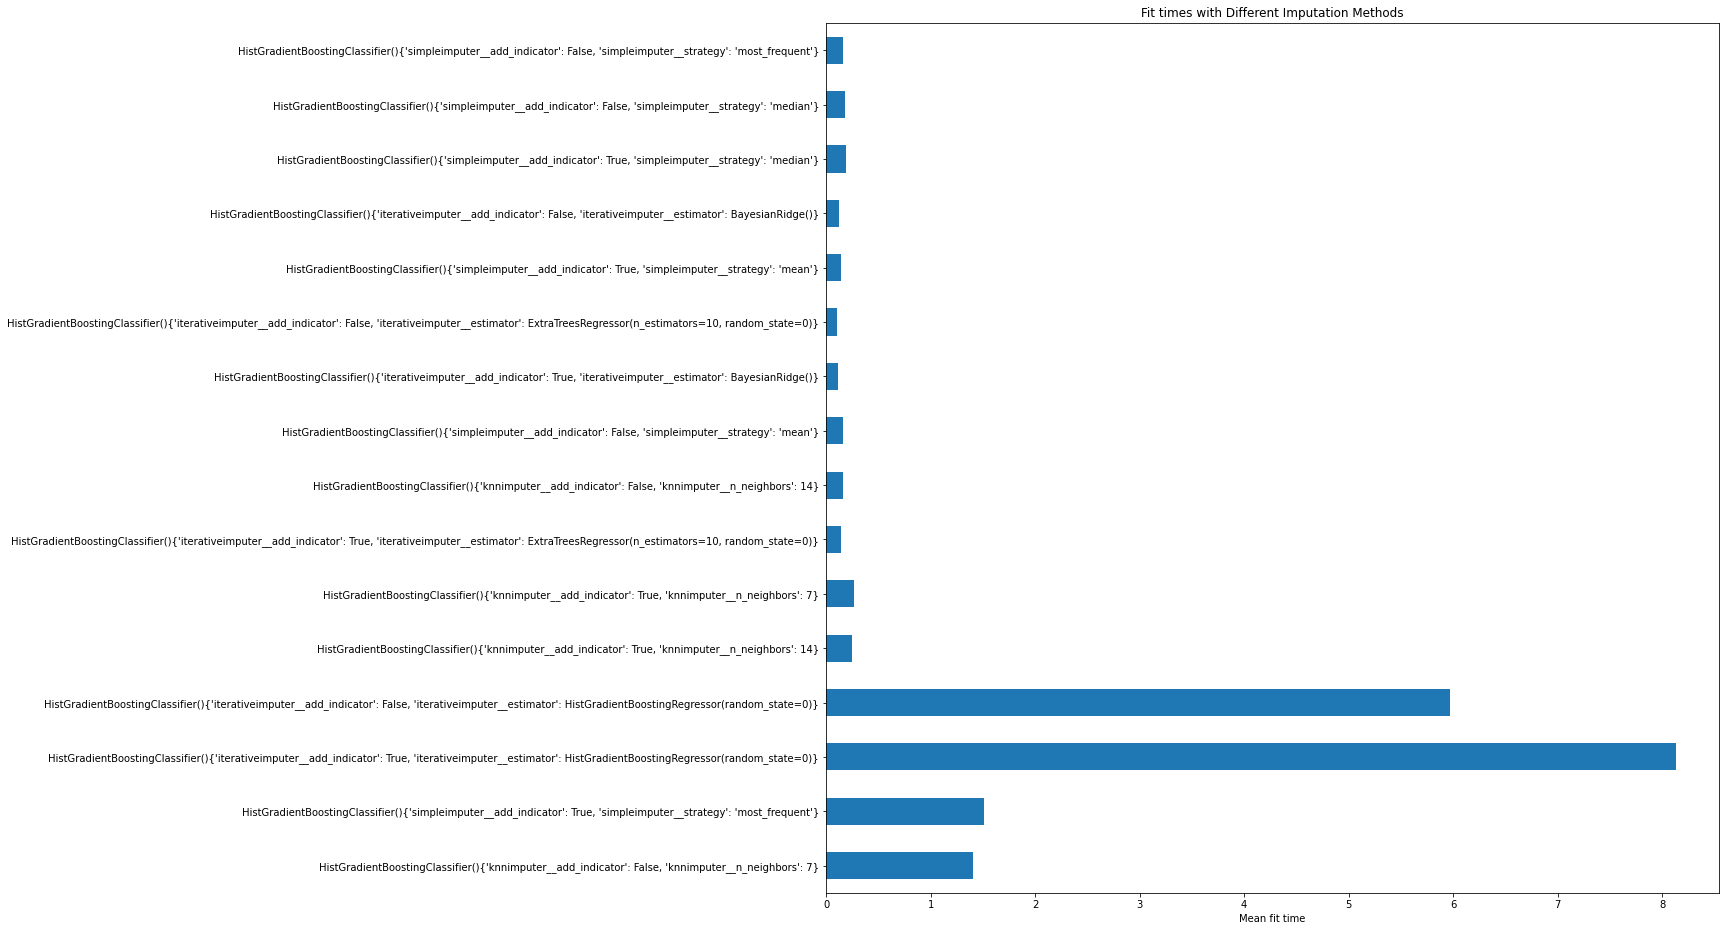

In [212]:
plot_results(df_results, 'Titanic', col= 'mean_fit_time')

Many categorical or small K ordinal columns here, an dknn imputer did best, but it's very similar. Simple imputer most frequent did well too.

## Notes maybe should add categorical columns back in to Ames and try that

## Pima Indians

In [235]:
data = pd.read_csv('datasets/diabetes.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/diabetes.csv'

In [255]:
def run_process(url, dataset_name, feature_cols, target, cols_to_encode=None, classification=False):
    '''the assembly routine
    
    Args:
    
        url (str): url of data in .csv
        dataset_name (str): name to call dataset
        feature_cols (list of str): columns to keep
        target_col (str): target column to predict
        cols_to_encode (list of str): columns to encode as numeric
        classification (Boolean): is the problem classification or regression
    
    
    Returns:
        results (pd.DataFrame): the results
    
    
    '''
    
    df = pd.read_csv(url)
    
    for col in df[feature_cols].columns:
        df[col] = df[col].factorize()[0]  # should technically OHE day, but this should be good enough

    y = df[target]
    X = df.drop(columns=target)

    X = make_missing(X)
    
    if classification:
        algo = HistGradientBoostingClassifier()
        regression=False
    else: 
        algo = HistGradientBoostingRegressor()

    results = combine_all_continuous(X, y, estimator_list=[algo])

    results = prep_results(results)


    plot_results(results, dataset_name, col= 'mean_test_score', regression=regression)

    plot_results(results, dataset_name, col= 'mean_score_time', regression=regression)

    plot_results(results, dataset_name, col= 'mean_fit_time', regression=regression)
    
    return results

## Titanic

In [ ]:
 df_titanic = run_process(
    url='', 
    dataset_name='titanic', 
    feature_cols=[],S
    target='survived',
    cols_to_encode=[],
    classification=True
    ) 

## Penguins

<ipython-input-230-6ea899123eb6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-230-6ea899123eb6>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,info,mean_test_score,mean_fit_time,mean_score_time,std_test_score
0,"HistGradientBoostingClassifier(){'iterativeimputer__add_indicator': False, 'iterativeimputer__estimator': BayesianRidge()}",0.938339,0.651359,0.025993,0.035382
1,"HistGradientBoostingClassifier(){'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'most_frequent'}",0.933131,0.559746,0.016291,0.050064
2,"HistGradientBoostingClassifier(){'iterativeimputer__add_indicator': True, 'iterativeimputer__estimator': BayesianRidge()}",0.929204,0.659028,0.025401,0.035086
3,"HistGradientBoostingClassifier(){'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 9}",0.922875,0.585357,0.025632,0.051396
4,"HistGradientBoostingClassifier(){'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'mean'}",0.920851,0.579085,0.017003,0.056022
5,"HistGradientBoostingClassifier(){'knnimputer__add_indicator': False, 'knnimputer__n_neighbors': 4}",0.918479,0.426981,0.016826,0.035121
6,"HistGradientBoostingClassifier(){'simpleimputer__add_indicator': True, 'simpleimputer__strategy': 'median'}",0.918263,0.580960,0.016401,0.058605
7,"HistGradientBoostingClassifier(){'iterativeimputer__add_indicator': False, 'iterativeimputer__estimator': ExtraTreesRegressor(n_estimators=10, random_state=0)}",0.916434,1.938012,0.146441,0.084169
8,"HistGradientBoostingClassifier(){'knnimputer__add_indicator': True, 'knnimputer__n_neighbors': 9}",0.915819,0.615318,0.026901,0.052934
9,"HistGradientBoostingClassifier(){'simpleimputer__add_indicator': False, 'simpleimputer__strategy': 'mean'}",0.910595,0.522236,0.016159,0.073232


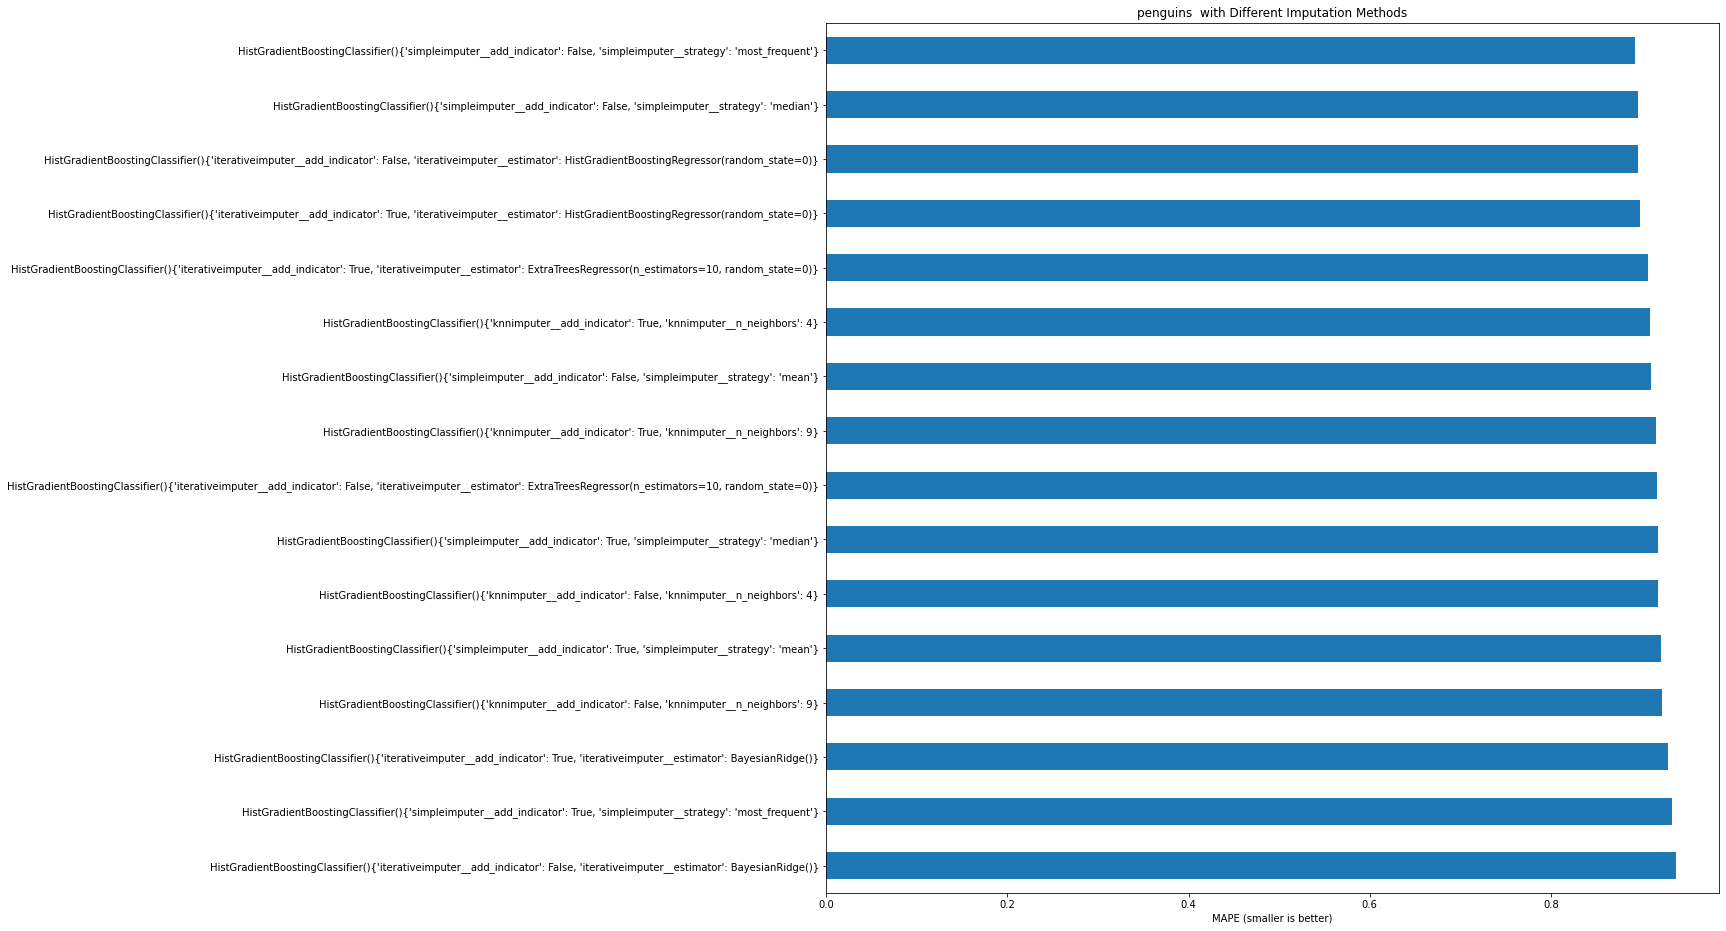

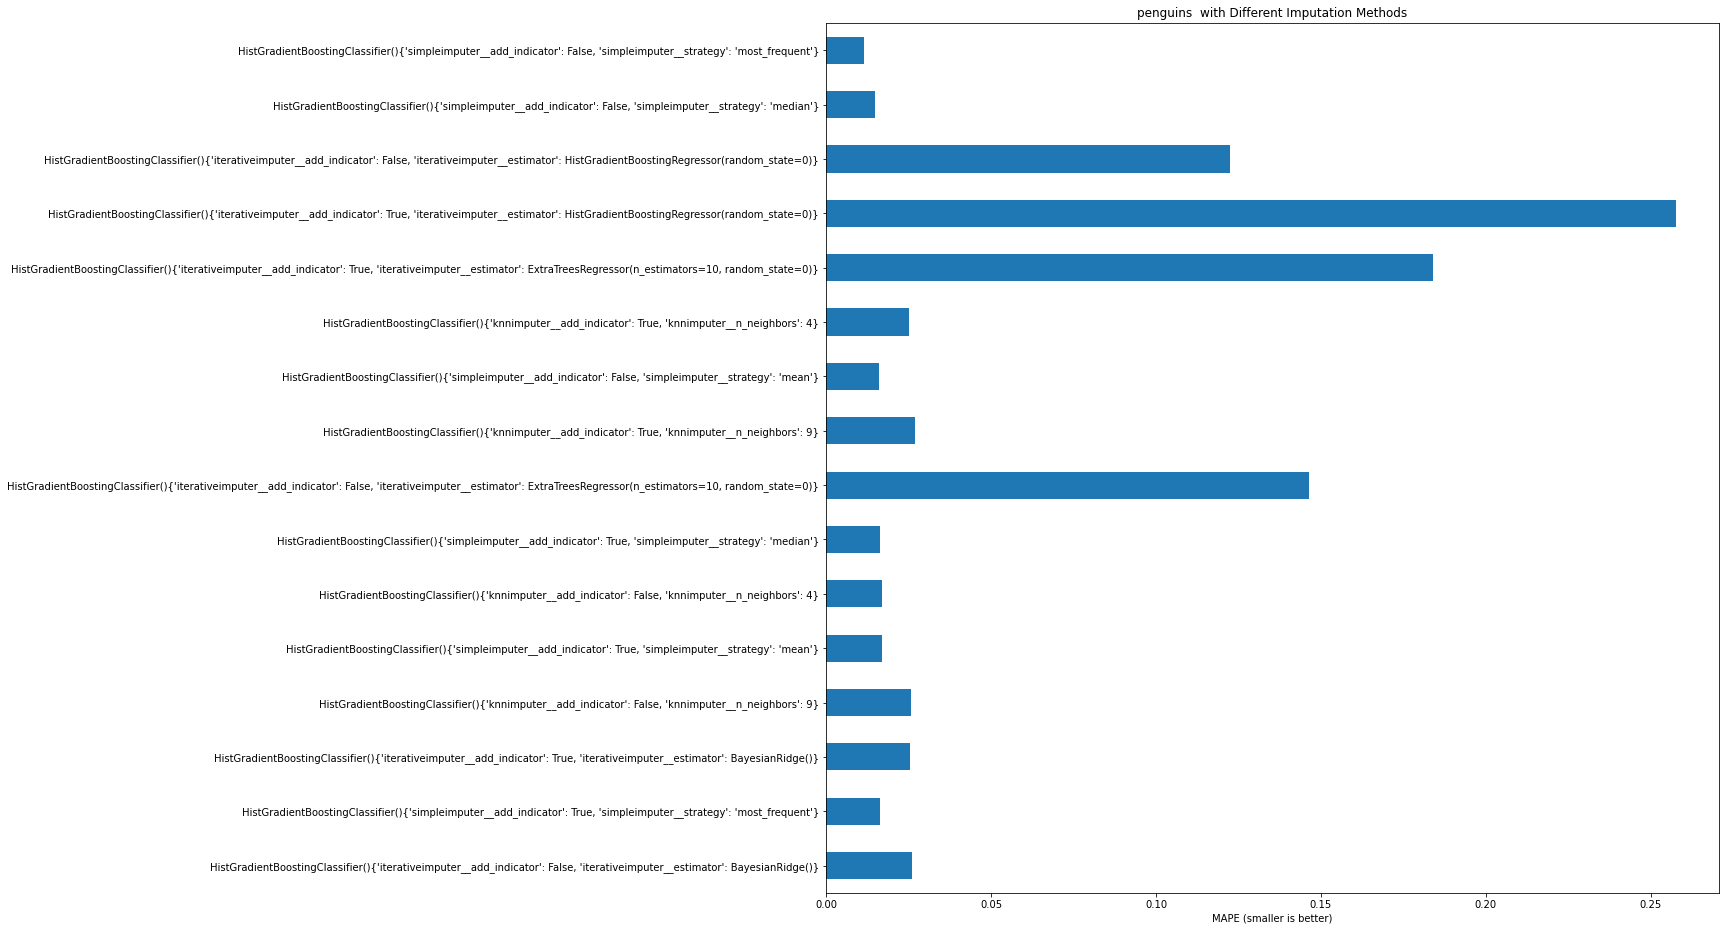

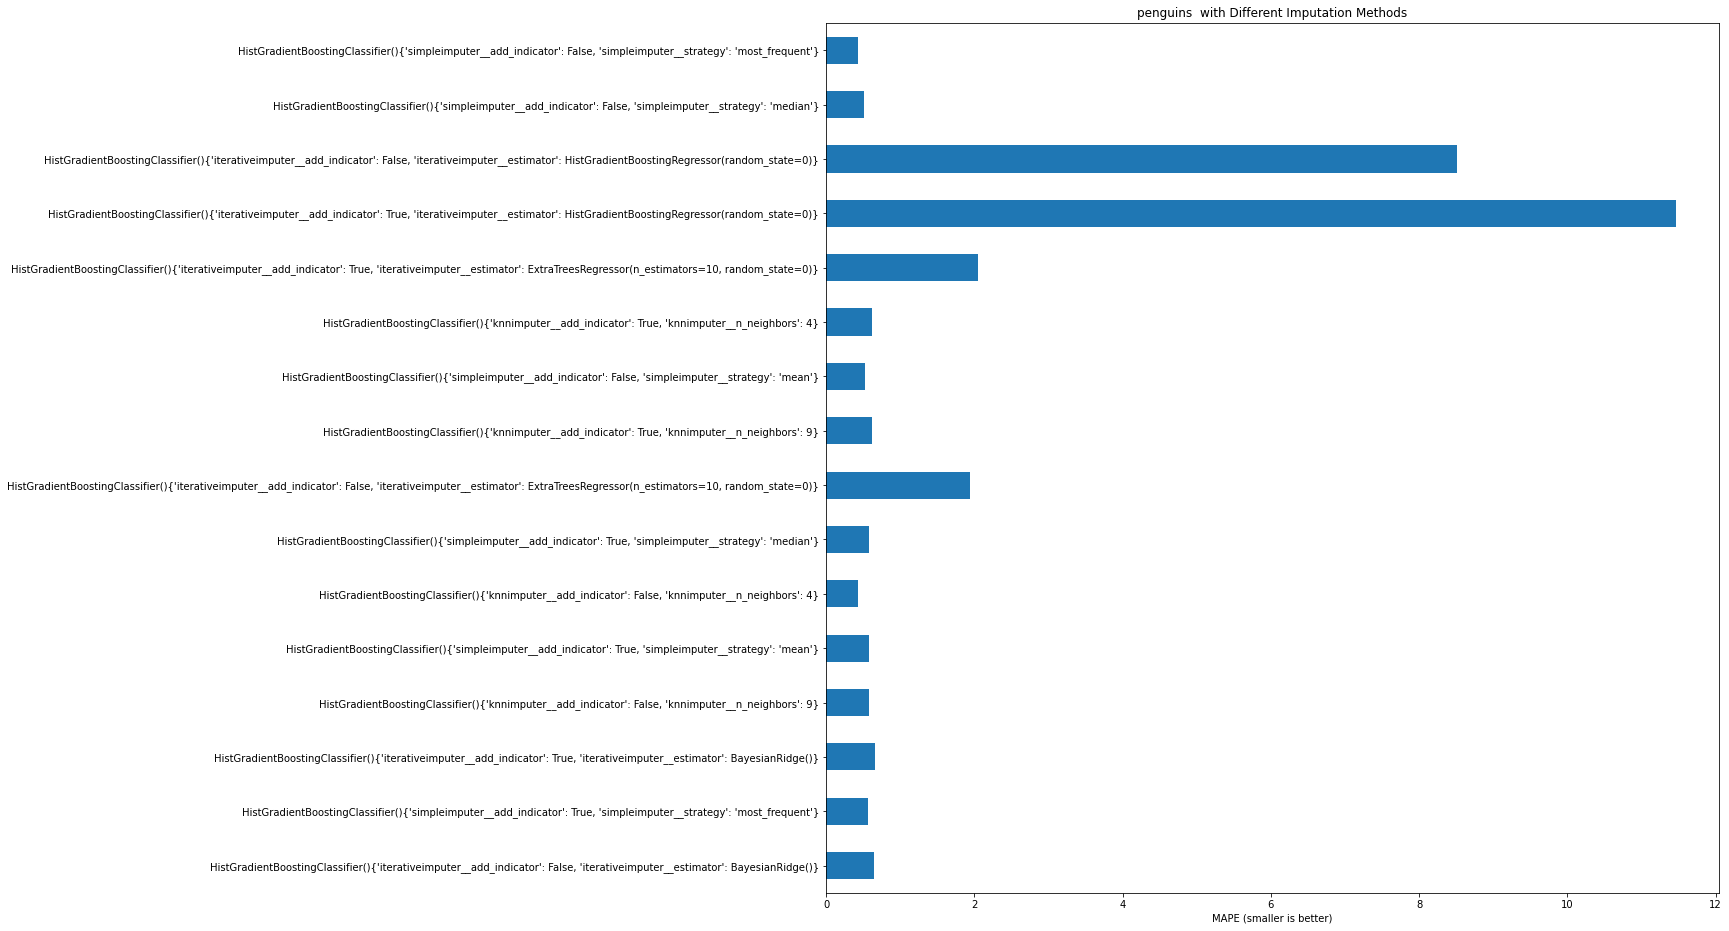

In [256]:
 df_pens = run_process(
    url='https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv', 
    dataset_name='penguins', 
    feature_cols=['island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex'],
    target='species',
    cols_to_encode=['island', 'sex'],
    classification=True
    )